<a href="https://colab.research.google.com/github/archie-cm/Churn-Analysis-Ecommerce-Customer/blob/main/Model_Survival_Analysis_Churn_Analysis_Ecommerse_Customer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Set Up

In [ ]:
! pip install lifelines==0.25.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 345 kB 5.2 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=93bc35a94c8def1986169c2f7cd56fd623b1582811e71e427d5aae7a26c0cee6
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


In [ ]:
# import and install all the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.calibration import calibration_curve 
from sklearn.metrics import brier_score_loss

from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

import lifelines

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
sns.set_style("whitegrid")

## Exploratory Data Analysis (EDA)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
description = pd.read_excel('/content/drive/MyDrive/E Commerce Dataset.xlsx', sheet_name='Data Dict', header=1, usecols=[1,2,3])
data = pd.read_excel('/content/drive/MyDrive/E Commerce Dataset.xlsx', sheet_name='E Comm')
data.head()

Mounted at /content/drive


CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1    4.00         Mobile Phone         3             6.00   
1       50002      1     NaN                Phone         1             8.00   
2       50003      1     NaN                Phone         1            30.00   
3       50004      1    0.00                Phone         3            15.00   
4       50005      1    0.00                Phone         1            12.00   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0           Debit Card  Female            3.00                         3   
1                  UPI    Male            3.00                         4   
2           Debit Card    Male            2.00                         4   
3           Debit Card    Male            2.00                         4   
4                   CC    Male             NaN                         3   

     PreferedOrderCat  SatisfactionScore MaritalStatus  NumberOfAddress  \
0  Laptop & Accessory                  2        Single                9   
1              Mobile                  3        Single                7   
2              Mobile                  3        Single                6   
3  Laptop & Accessory                  5        Single                8   
4              Mobile                  5        Single                3   

   Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
0         1                        11.00        1.00        1.00   
1         1                        15.00        0.00        1.00   
2         1                        14.00        0.00        1.00   
3         0                        23.00        0.00        1.00   
4         0                        11.00        1.00        1.00   

   DaySinceLastOrder  CashbackAmount  
0               5.00          159.93  
1               0.00          120.90  
2               3.00          120.28  
3               3.00          134.07  
4               3.00          129.60

Pada tahapan EDA ini akan dilakukan :

1. Pengujian korelasi untuk mengetahui feature mana saja yang berpengaruh kuat terhadap label (Churn)
2. Informasi dari proporsi masing - masing feature terhadap label (Churn) untuk melihat karakterstiknya
3. Karakteristik dan faktor yang berpengaruh terhadap label (Churn)

## Data Preprocessing

Pada tahap ini, akan dilakukan cleaning pada data untuk kebutuhan proses analisis selanjutnya. Beberapa hal yang perlu dilakukan adalah:
1. Melakukan pengecekan terhadap duplikat data, missing value, dan drop fitur yang tidak memiliki relevansi terhadap permasalahan yang sedang dihadapi.
2. Melakukan treatment terhadap missing value jika ada. Hal ini dilakukan dengan cara men-drop fiturnya jika memang tidak dibutuhkan, mendrop data duplikat, menyatukan fitur yang memiliki kemiripan nama, mengganti nama data menjadi nama yang lebih umum dipakai dan  mengimputasi dengan nilai yang paling masuk akal berdasarkan kasusnya.

In [ ]:
# Save customerID and MonthlyCharges columns in a separate DF and drop it from the main DF
nochurn_customers = data[data['Churn'] == 0]
customerID = pd.DataFrame(nochurn_customers[['CustomerID','CashbackAmount']])
data.drop(columns = ['CustomerID'], inplace=True)

### Handling Duplicate Value

Pada tahap ini akan dilakukan penggabungan untuk feature yang memiliki kesamaan nilai namun terdapat perbedaan dalam penulisannya.

In [ ]:
data['PreferredLoginDevice'].value_counts()

Mobile Phone    2765
Computer        1634
Phone           1231
Name: PreferredLoginDevice, dtype: int64

Dalam kolom 'PreferredLoginDevice' yang berarti pelanggan menggunakan perangkat jenis apa dalam mengakses online ecommerce perusahaan terdapat kesamaan makna antara 'Mobile Phone' dengan 'Phone' dimana hal tersebut dapat disatukan / disamakan nilainya menjadi 'Mobile Phone'.

In [ ]:
data.loc[data['PreferredLoginDevice'] == 'Phone', 'PreferredLoginDevice' ] = 'Mobile Phone'

In [ ]:
data['PreferredLoginDevice'].value_counts()

Mobile Phone    3996
Computer        1634
Name: PreferredLoginDevice, dtype: int64

In [ ]:
data['PreferredPaymentMode'].value_counts()

Debit Card          2314
Credit Card         1501
E wallet             614
UPI                  414
COD                  365
CC                   273
Cash on Delivery     149
Name: PreferredPaymentMode, dtype: int64

Dalam kolom 'PreferredPaymentMode' yang berarti pelanggan menggunakan metode pembayaran apa dalam transaksi di online ecommerce perusahaan terdapat kesamaan makna antara 'Credit Card' dengan 'CC' dimana hal tersebut dapat disatukan / disamakan nilainya menjadi 'Credit Card', lalu 'Cash on Delivery' dengan 'COD' dapat disatukan nilainua menjadi 'Cash on Delivery'.

In [ ]:
data.loc[data['PreferredPaymentMode'] == 'COD', 'PreferredPaymentMode' ] = 'Cash on Delivery'  
data.loc[data['PreferredPaymentMode'] == 'CC', 'PreferredPaymentMode' ] = 'Credit Card'

In [ ]:
data['PreferredPaymentMode'].value_counts()

Debit Card          2314
Credit Card         1774
E wallet             614
Cash on Delivery     514
UPI                  414
Name: PreferredPaymentMode, dtype: int64

In [ ]:
data['PreferedOrderCat'].value_counts()

Laptop & Accessory    2050
Mobile Phone          1271
Fashion                826
Mobile                 809
Grocery                410
Others                 264
Name: PreferedOrderCat, dtype: int64

Dalam kolom 'PreferedOrderCat' yang berarti jenis produk yang banyak dibeli oleh pelanggan di online ecommerce perusahaan terdapat kesamaan makna antara 'Mobile Phone' dengan 'Mobile' dimana hal tersebut dapat disatukan / disamakan nilainya menjadi 'Mobile Phone'.

In [ ]:
data.loc[data['PreferedOrderCat'] == 'Mobile', 'PreferedOrderCat' ] = 'Mobile Phone'

In [ ]:
data['PreferedOrderCat'].value_counts()

Mobile Phone          2080
Laptop & Accessory    2050
Fashion                826
Grocery                410
Others                 264
Name: PreferedOrderCat, dtype: int64

In [ ]:
data['MaritalStatus'].value_counts()

Married     2986
Single      1796
Divorced     848
Name: MaritalStatus, dtype: int64

In [ ]:
data['Gender'].value_counts()

Male      3384
Female    2246
Name: Gender, dtype: int64

### Handling Duplicate Data

Pada tahap ini akan dihapus untuk baris data yang memiliki nilai yang sama.

In [ ]:
print("Number of duplicate rows: ", sum(data.duplicated()))

Number of duplicate rows:  557


Terdapat 557 baris yang memiliki kesamaan nilai, selanjutnya baris tersebut akan dihapus.

In [ ]:
# Drop duplicate data
data.drop_duplicates(inplace=True)

# Cehck duplicate data
print("Number of duplicate rows: ", sum(data.duplicated()))

Number of duplicate rows:  0


### Handling Missing Value

Pada tahap ini akan dilakukan analisis terhadap data missing value seperti penyebab hingga solusi untuk mengatasinya.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5073 entries, 0 to 5629
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        5073 non-null   int64  
 1   Tenure                       4842 non-null   float64
 2   PreferredLoginDevice         5073 non-null   object 
 3   CityTier                     5073 non-null   int64  
 4   WarehouseToHome              4852 non-null   float64
 5   PreferredPaymentMode         5073 non-null   object 
 6   Gender                       5073 non-null   object 
 7   HourSpendOnApp               4843 non-null   float64
 8   NumberOfDeviceRegistered     5073 non-null   int64  
 9   PreferedOrderCat             5073 non-null   object 
 10  SatisfactionScore            5073 non-null   int64  
 11  MaritalStatus                5073 non-null   object 
 12  NumberOfAddress              5073 non-null   int64  
 13  Complain          

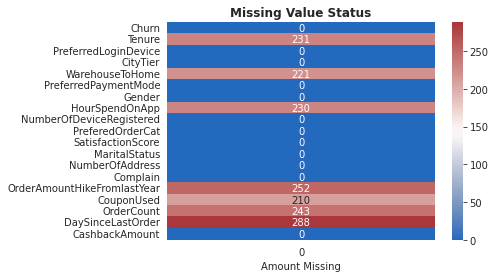

In [ ]:
plt.title('Missing Value Status',fontweight='bold')
ax = sns.heatmap(data.isna().sum().to_frame(),annot=True,fmt='d',cmap='vlag')
ax.set_xlabel('Amount Missing')
plt.show()

In [ ]:
percentage_of_null_values = ((data.isnull().sum())*100/len(data)).sort_values(ascending = False)
percentage_of_null_values

DaySinceLastOrder             5.68
OrderAmountHikeFromlastYear   4.97
OrderCount                    4.79
Tenure                        4.55
HourSpendOnApp                4.53
WarehouseToHome               4.36
CouponUsed                    4.14
Churn                         0.00
MaritalStatus                 0.00
Complain                      0.00
NumberOfAddress               0.00
PreferedOrderCat              0.00
SatisfactionScore             0.00
NumberOfDeviceRegistered      0.00
Gender                        0.00
PreferredPaymentMode          0.00
CityTier                      0.00
PreferredLoginDevice          0.00
CashbackAmount                0.00
dtype: float64

In [ ]:
null_values = ((data.isnull().sum())).sort_values(ascending = False)
null_values

DaySinceLastOrder              288
OrderAmountHikeFromlastYear    252
OrderCount                     243
Tenure                         231
HourSpendOnApp                 230
WarehouseToHome                221
CouponUsed                     210
Churn                            0
MaritalStatus                    0
Complain                         0
NumberOfAddress                  0
PreferedOrderCat                 0
SatisfactionScore                0
NumberOfDeviceRegistered         0
Gender                           0
PreferredPaymentMode             0
CityTier                         0
PreferredLoginDevice             0
CashbackAmount                   0
dtype: int64

Dapat dilihat terdapat 7 feature memiliki missing value dengan presentase > 4%, sehingga harus dilakukan penyesuaian agar tidak bermasalah untuk model. Sebelum memutuskan akan diselesaikan dengan cara seperti apa, kita harus mengetahui terlebih dahulu potensi penyebab data tersebut missing.

#### Missing Value : DaySinceLastOrder

In [ ]:
data["DaySinceLastOrder"].unique()

array([ 5.,  0.,  3.,  7.,  2.,  1.,  8.,  6.,  4., 15.,  9., 11., 10.,
       nan, 13., 12., 17., 16., 14., 30., 46., 18., 31.])

DaySinceLastOrder merupakan rentang hari sejak transaksi terakhir, nilai 'nan' bisa jadi karena pelanggan baru atau pelanggan tersebut baru pertama kali melakukan transaksi. Oleh karena itu untuk membuktikan asumsi tersebut dilakukan pengecekan total order yang pernah dilakukan untuk data yang DaySinceLastOrder yang missing. 

In [ ]:
data_null = data[data['DaySinceLastOrder'].isna()].copy()
data_null

Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
88        0   24.00         Mobile Phone         1            14.00   
97        0   10.00             Computer         1            17.00   
126       0   12.00             Computer         1             8.00   
146       1   10.00             Computer         1            35.00   
151       0    2.00         Mobile Phone         1            28.00   
...     ...     ...                  ...       ...              ...   
5574      0   21.00         Mobile Phone         1            32.00   
5591      0    6.00         Mobile Phone         3             8.00   
5608      0   15.00         Mobile Phone         3            10.00   
5623      0    5.00             Computer         1            12.00   
5626      0   13.00         Mobile Phone         1            13.00   

     PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
88             Debit Card    Male            2.00                         4   
97                    UPI    Male            2.00                         3   
126      Cash on Delivery  Female            3.00                         3   
146            Debit Card    Male            2.00                         3   
151            Debit Card  Female            3.00                         2   
...                   ...     ...             ...                       ...   
5574          Credit Card    Male            3.00                         4   
5591             E wallet  Female            3.00                         4   
5608           Debit Card    Male            3.00                         5   
5623          Credit Card    Male            4.00                         4   
5626          Credit Card    Male            3.00                         5   

        PreferedOrderCat  SatisfactionScore MaritalStatus  NumberOfAddress  \
88               Fashion                  4      Divorced                6   
97               Fashion                  2       Married                2   
126              Fashion                  3        Single                1   
146              Fashion                  4      Divorced                2   
151              Fashion                  4       Married                8   
...                  ...                ...           ...              ...   
5574             Fashion                  3        Single                4   
5591             Fashion                  1       Married                3   
5608  Laptop & Accessory                  4       Married                4   
5623  Laptop & Accessory                  5        Single                2   
5626             Fashion                  5       Married                6   

      Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
88           0                        16.00        1.00        4.00   
97           1                        14.00        0.00        1.00   
126          0                        25.00       10.00       11.00   
146          1                        12.00        5.00        9.00   
151          0                        18.00        5.00        6.00   
...        ...                          ...         ...         ...   
5574         0                        24.00       10.00       13.00   
5591         0                        20.00        1.00        6.00   
5608         0                        12.00        2.00        2.00   
5623         0                        20.00        2.00        2.00   
5626         0                        16.00        1.00        2.00   

      DaySinceLastOrder  CashbackAmount  
88                  NaN          224.90  
97                  NaN          221.85  
126                 NaN          209.38  
146                 NaN          218.49  
151                 NaN          219.96  
...                 ...             ...  
5574                NaN          211.33  
5591                NaN          229.22  
5608                NaN          214

In [ ]:
data_null[data_null['OrderCount']<1]

Empty DataFrame
Columns: [Churn, Tenure, PreferredLoginDevice, CityTier, WarehouseToHome, PreferredPaymentMode, Gender, HourSpendOnApp, NumberOfDeviceRegistered, PreferedOrderCat, SatisfactionScore, MaritalStatus, NumberOfAddress, Complain, OrderAmountHikeFromlastYear, CouponUsed, OrderCount, DaySinceLastOrder, CashbackAmount]
Index: []

In [ ]:
data_null[data_null['OrderCount'].isna()]

Empty DataFrame
Columns: [Churn, Tenure, PreferredLoginDevice, CityTier, WarehouseToHome, PreferredPaymentMode, Gender, HourSpendOnApp, NumberOfDeviceRegistered, PreferedOrderCat, SatisfactionScore, MaritalStatus, NumberOfAddress, Complain, OrderAmountHikeFromlastYear, CouponUsed, OrderCount, DaySinceLastOrder, CashbackAmount]
Index: []

Dapat dilihat untuk nilai DaySinceLastOrder yang missing, seluruhnya memiliki nilai ordercount >= 1. Artinya data tersebut bukan merepresentasikan pelanggan baru atau pelanggan yang pertama kali melakukan transaksi. Dimungkinkan missing value disebabkan karena data tidak terinput.

#### Missing Value : OrderAmountHikeFromlastYear

In [ ]:
data["OrderAmountHikeFromlastYear"].unique()

array([11., 15., 14., 23., 22., 16., 12., nan, 13., 17., 18., 24., 19.,
       20., 21., 25., 26.])

OrderAmountHikeFromlastYear merupakan Kenaikan presentase transaksi dari tahun lalu, nilai 'nan' bisa jadi karena pelanggan baru atau pelanggan tersebut baru pertama kali melakukan transaksi. Oleh karena itu untuk membuktikan asumsi tersebut dilakukan pengecekan total order yang pernah dilakukan untuk data yang OrderAmountHikeFromlastYear yang missing.

In [ ]:
data_null = data[data['OrderAmountHikeFromlastYear'].isna()].copy()
data_null

Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
10        1    4.00         Mobile Phone         1            18.00   
40        0   23.00         Mobile Phone         1            17.00   
65        0   25.00         Mobile Phone         1             6.00   
106       0   15.00         Mobile Phone         1            10.00   
108       0   23.00         Mobile Phone         3             6.00   
...     ...     ...                  ...       ...              ...   
5511      0   22.00             Computer         1            29.00   
5534      0   61.00         Mobile Phone         3            28.00   
5537      0   23.00             Computer         1             9.00   
5597      0   13.00             Computer         1            16.00   
5603      0   16.00         Mobile Phone         1             9.00   

     PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
10       Cash on Delivery  Female            2.00                         3   
40             Debit Card  Female            2.00                         3   
65             Debit Card    Male            3.00                         4   
106      Cash on Delivery    Male            2.00                         3   
108           Credit Card  Female            3.00                         3   
...                   ...     ...             ...                       ...   
5511          Credit Card  Female            3.00                         4   
5534           Debit Card  Female            4.00                         4   
5537           Debit Card    Male            3.00                         4   
5597           Debit Card    Male            3.00                         4   
5603           Debit Card    Male            3.00                         4   

     PreferedOrderCat  SatisfactionScore MaritalStatus  NumberOfAddress  \
10             Others                  3      Divorced                2   
40             Others                  4        Single                4   
65             Others                  3      Divorced                1   
106            Others                  2      Divorced                2   
108            Others                  2       Married                4   
...               ...                ...           ...              ...   
5511          Grocery                  1       Married                5   
5534          Grocery                  1       Married                6   
5537           Others                  1       Married                5   
5597           Others                  1        Single                4   
5603           Others                  3       Married                7   

      Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
10           0                          NaN        9.00       15.00   
40           0                          NaN        2.00        4.00   
65           0                          NaN        1.00       11.00   
106          0                          NaN        0.00       11.00   
108          0                          NaN        1.00        1.00   
...        ...                          ...         ...         ...   
5511         0                          NaN        2.00        5.00   
5534         1                          NaN        1.00        2.00   
5537         0                          NaN        5.00        5.00   
5597         0                          NaN        2.00        2.00   
5603         0                          NaN        1.00        5.00   

      DaySinceLastOrder  CashbackAmount  
10                 8.00          295.45  
40                 4.00          299.26  
65                 9.00          299.99  
106               15.00          292.32  
108                6.00          295.17  
...                 ...             ...  
5511               8.00          296.74  
5534               1.00          303.75  
5537               4.00          316.61  
5597               4.00       

In [ ]:
data_null[data_null['OrderCount']<1]

Empty DataFrame
Columns: [Churn, Tenure, PreferredLoginDevice, CityTier, WarehouseToHome, PreferredPaymentMode, Gender, HourSpendOnApp, NumberOfDeviceRegistered, PreferedOrderCat, SatisfactionScore, MaritalStatus, NumberOfAddress, Complain, OrderAmountHikeFromlastYear, CouponUsed, OrderCount, DaySinceLastOrder, CashbackAmount]
Index: []

In [ ]:
data_null[data_null['OrderCount'].isna()]

Empty DataFrame
Columns: [Churn, Tenure, PreferredLoginDevice, CityTier, WarehouseToHome, PreferredPaymentMode, Gender, HourSpendOnApp, NumberOfDeviceRegistered, PreferedOrderCat, SatisfactionScore, MaritalStatus, NumberOfAddress, Complain, OrderAmountHikeFromlastYear, CouponUsed, OrderCount, DaySinceLastOrder, CashbackAmount]
Index: []

Dapat dilihat untuk nilai OrderAmountHikeFromlastYear yang missing, seluruhnya memiliki nilai ordercount >= 1. Artinya data tersebut bukan merepresentasikan pelanggan baru atau pelanggan yang pertama kali melakukan transaksi. Dimungkinkan missing value disebabkan karena data tidak terinput.

#### Missing Value : Tenure

In [ ]:
data["Tenure"].unique()

array([ 4., nan,  0., 13., 11.,  9., 19., 20., 14.,  8., 18.,  5.,  2.,
       30.,  1., 23.,  3., 29.,  6., 26., 28.,  7., 24., 25., 10., 15.,
       22., 27., 16., 12., 21., 17., 50., 60., 31., 51., 61.])

Tenure merupakan masa berlangganan dari pelanggan, Pelanggan baru sudah direpresentasikan dengan nilai 0, kemungkinan nilai 'nan' karena tidak terinput.

#### Missing Value : OrderCount

In [ ]:
data["OrderCount"].unique()

array([ 1.,  6.,  2., 15.,  4.,  7.,  3.,  9., nan, 11.,  5., 12., 10.,
        8., 13., 14., 16.])

OrderCount merupakan Total order pada bulan lalu, nilai 'nan' bisa jadi karena pelanggan baru atau pelanggan tersebut baru pertama kali melakukan transaksi. Oleh karena itu untuk membuktikan asumsi tersebut dilakukan pengecekan terhadap adanya peningkatan transaksi yang dilakukan untuk data yang OrderCount yang missing.

In [ ]:
data_null = data[data['OrderCount'].isna()].copy()
data_null

Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
64        0   24.00         Mobile Phone         1             9.00   
90        0   14.00         Mobile Phone         3            12.00   
110       0   16.00         Mobile Phone         3            22.00   
120       0    4.00             Computer         1             9.00   
143       0   18.00         Mobile Phone         1            26.00   
...     ...     ...                  ...       ...              ...   
5517      0   16.00         Mobile Phone         1            13.00   
5581      0   21.00             Computer         1             8.00   
5590      0   12.00         Mobile Phone         1            17.00   
5621      1   14.00         Mobile Phone         3            35.00   
5622      0   13.00         Mobile Phone         3            31.00   

     PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
64            Credit Card  Female            3.00                         3   
90             Debit Card  Female            3.00                         3   
110              E wallet  Female            3.00                         3   
120           Credit Card    Male            3.00                         3   
143           Credit Card    Male            3.00                         3   
...                   ...     ...             ...                       ...   
5517          Credit Card    Male            3.00                         4   
5581          Credit Card  Female            4.00                         4   
5590          Credit Card  Female            4.00                         6   
5621             E wallet    Male            3.00                         5   
5622             E wallet  Female            3.00                         5   

     PreferedOrderCat  SatisfactionScore MaritalStatus  NumberOfAddress  \
64            Grocery                  4        Single                4   
90            Fashion                  2        Single                4   
110           Grocery                  2      Divorced                6   
120           Fashion                  3       Married               10   
143           Grocery                  2      Divorced                1   
...               ...                ...           ...              ...   
5517          Fashion                  5       Married               11   
5581          Fashion                  4       Married                2   
5590          Fashion                  3       Married                5   
5621          Fashion                  5       Married                6   
5622          Grocery                  1       Married                2   

      Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
64           0                        18.00        0.00         NaN   
90           1                        18.00        0.00         NaN   
110          1                        22.00        0.00         NaN   
120          0                        12.00        1.00         NaN   
143          1                        14.00        0.00         NaN   
...        ...                          ...         ...         ...   
5517         0                        14.00        6.00         NaN   
5581         0                        19.00        1.00         NaN   
5590         0                        13.00        1.00         NaN   
5621         1                        14.00        3.00         NaN   
5622         0                        12.00        4.00         NaN   

      DaySinceLastOrder  CashbackAmount  
64                 0.00          237.34  
90                 0.00          235.91  
110                9.00          260.64  
120                2.00          236.75  
143               10.00          234.96  
...                 ...             ...  
5517               8.00          258.48  
5581              13.00          244.57  
5590              12.00          257.06  
5621               1.00       

In [ ]:
data_null[data_null['OrderAmountHikeFromlastYear']<1]

Empty DataFrame
Columns: [Churn, Tenure, PreferredLoginDevice, CityTier, WarehouseToHome, PreferredPaymentMode, Gender, HourSpendOnApp, NumberOfDeviceRegistered, PreferedOrderCat, SatisfactionScore, MaritalStatus, NumberOfAddress, Complain, OrderAmountHikeFromlastYear, CouponUsed, OrderCount, DaySinceLastOrder, CashbackAmount]
Index: []

In [ ]:
data_null[data_null['OrderAmountHikeFromlastYear'].isna()]

Empty DataFrame
Columns: [Churn, Tenure, PreferredLoginDevice, CityTier, WarehouseToHome, PreferredPaymentMode, Gender, HourSpendOnApp, NumberOfDeviceRegistered, PreferedOrderCat, SatisfactionScore, MaritalStatus, NumberOfAddress, Complain, OrderAmountHikeFromlastYear, CouponUsed, OrderCount, DaySinceLastOrder, CashbackAmount]
Index: []

Dapat dilihat untuk nilai OrderCount yang missing, seluruhnya memiliki nilai OrderAmountHikeFromlastYear > 1. Artinya data tersebut bukan merepresentasikan pelanggan baru atau pelanggan yang pertama kali melakukan transaksi. Dimungkinkan missing value disebabkan karena data tidak terinput.

#### Missing Value : CouponUsed

In [ ]:
data["CouponUsed"].unique()

array([ 1.,  0.,  4.,  2.,  9.,  6., 11., nan,  7., 12., 10.,  5.,  3.,
       13., 15.,  8., 14., 16.])

CouponUsed merupakan Total penggunanaan kupon pada bulan lalu, nilai 'nan' bisa jadi karena pelanggan baru atau pelanggan tersebut baru pertama kali melakukan transaksi. Oleh karena itu untuk membuktikan asumsi tersebut dilakukan pengecekan total order yang pernah dilakukan untuk data yang OrderAmountHikeFromlastYear yang missing.

In [ ]:
data_null = data[data['CouponUsed'].isna()].copy()
data_null

Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
61        0   13.00         Mobile Phone         1            10.00   
62        0   28.00         Mobile Phone         1            20.00   
69        0   18.00             Computer         1             8.00   
112       0   25.00             Computer         3             8.00   
138       0   19.00         Mobile Phone         3             8.00   
...     ...     ...                  ...       ...              ...   
5170      0   29.00         Mobile Phone         1             8.00   
5238      0   18.00         Mobile Phone         1            35.00   
5240      0   20.00         Mobile Phone         3            10.00   
5355      0   23.00         Mobile Phone         1             8.00   
5461      0   31.00             Computer         3             9.00   

     PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
61            Credit Card  Female            2.00                         3   
62            Credit Card    Male            3.00                         2   
69            Credit Card    Male            3.00                         4   
112            Debit Card    Male            3.00                         4   
138      Cash on Delivery  Female            3.00                         5   
...                   ...     ...             ...                       ...   
5170          Credit Card    Male            3.00                         2   
5238           Debit Card    Male            3.00                         4   
5240           Debit Card  Female            3.00                         4   
5355           Debit Card    Male            3.00                         4   
5461          Credit Card    Male            3.00                         4   

     PreferedOrderCat  SatisfactionScore MaritalStatus  NumberOfAddress  \
61             Others                  3      Divorced                2   
62             Others                  4        Single                9   
69            Grocery                  2      Divorced               10   
112            Others                  3        Single                2   
138           Grocery                  4      Divorced                4   
...               ...                ...           ...              ...   
5170          Grocery                  1       Married                4   
5238          Grocery                  5       Married                5   
5240          Grocery                  4       Married               10   
5355          Grocery                  3        Single                6   
5461          Grocery                  4       Married                6   

      Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
61           0                        14.00         NaN        9.00   
62           0                        11.00         NaN        2.00   
69           0                        23.00         NaN       11.00   
112          1                        18.00         NaN       15.00   
138          1                        12.00         NaN        7.00   
...        ...                          ...         ...         ...   
5170         0                        14.00         NaN        2.00   
5238         0                        14.00         NaN       15.00   
5240         0                        13.00         NaN        6.00   
5355         0                        15.00         NaN        2.00   
5461         0                        23.00         NaN       15.00   

      DaySinceLastOrder  CashbackAmount  
61                 9.00          290.33  
62                15.00          287.22  
69                 8.00          267.92  
112               12.00          290.68  
138                7.00          268.72  
...                 ...             ...  
5170               1.00          272.32  
5238              18.00          288.28  
5240               2.00          291.06  
5355               1.00       

In [ ]:
data_null[data_null['OrderCount']<1]

Empty DataFrame
Columns: [Churn, Tenure, PreferredLoginDevice, CityTier, WarehouseToHome, PreferredPaymentMode, Gender, HourSpendOnApp, NumberOfDeviceRegistered, PreferedOrderCat, SatisfactionScore, MaritalStatus, NumberOfAddress, Complain, OrderAmountHikeFromlastYear, CouponUsed, OrderCount, DaySinceLastOrder, CashbackAmount]
Index: []

In [ ]:
data_null[data_null['OrderCount'].isna()]

Empty DataFrame
Columns: [Churn, Tenure, PreferredLoginDevice, CityTier, WarehouseToHome, PreferredPaymentMode, Gender, HourSpendOnApp, NumberOfDeviceRegistered, PreferedOrderCat, SatisfactionScore, MaritalStatus, NumberOfAddress, Complain, OrderAmountHikeFromlastYear, CouponUsed, OrderCount, DaySinceLastOrder, CashbackAmount]
Index: []

Dapat dilihat untuk nilai CouponUsed yang missing, seluruhnya memiliki nilai ordercount >= 1. Artinya data tersebut bukan merepresentasikan pelanggan baru atau pelanggan yang pertama kali melakukan transaksi. Dimungkinkan missing value disebabkan karena data tidak terinput.

#### Missing Value : HourSpendOnApp

In [ ]:
data["HourSpendOnApp"].unique()

array([ 3.,  2., nan,  1.,  0.,  4.,  5.])

HourSpendOnApp merupakan lama waktu pelanggan online di aplikasi, Pelanggan baru sudah direpresentasikan dengan nilai 0, kemungkinan nilai 'nan' karena tidak terinput.

#### Missing Value : WarehouseToHome

In [ ]:
data["WarehouseToHome"].unique()

array([  6.,   8.,  30.,  15.,  12.,  22.,  11.,   9.,  31.,  18.,  13.,
        20.,  29.,  28.,  26.,  14.,  nan,  10.,  27.,  17.,  23.,  33.,
        19.,  35.,  24.,  16.,  25.,  32.,  34.,   5.,  21., 126.,   7.,
        36., 127.])

WarehouseToHome merupakan Jarak gudang ke alamat pelanggan, kemungkinan nilai 'nan' karena tidak terinput.

Text(0, 0.5, 'Values')

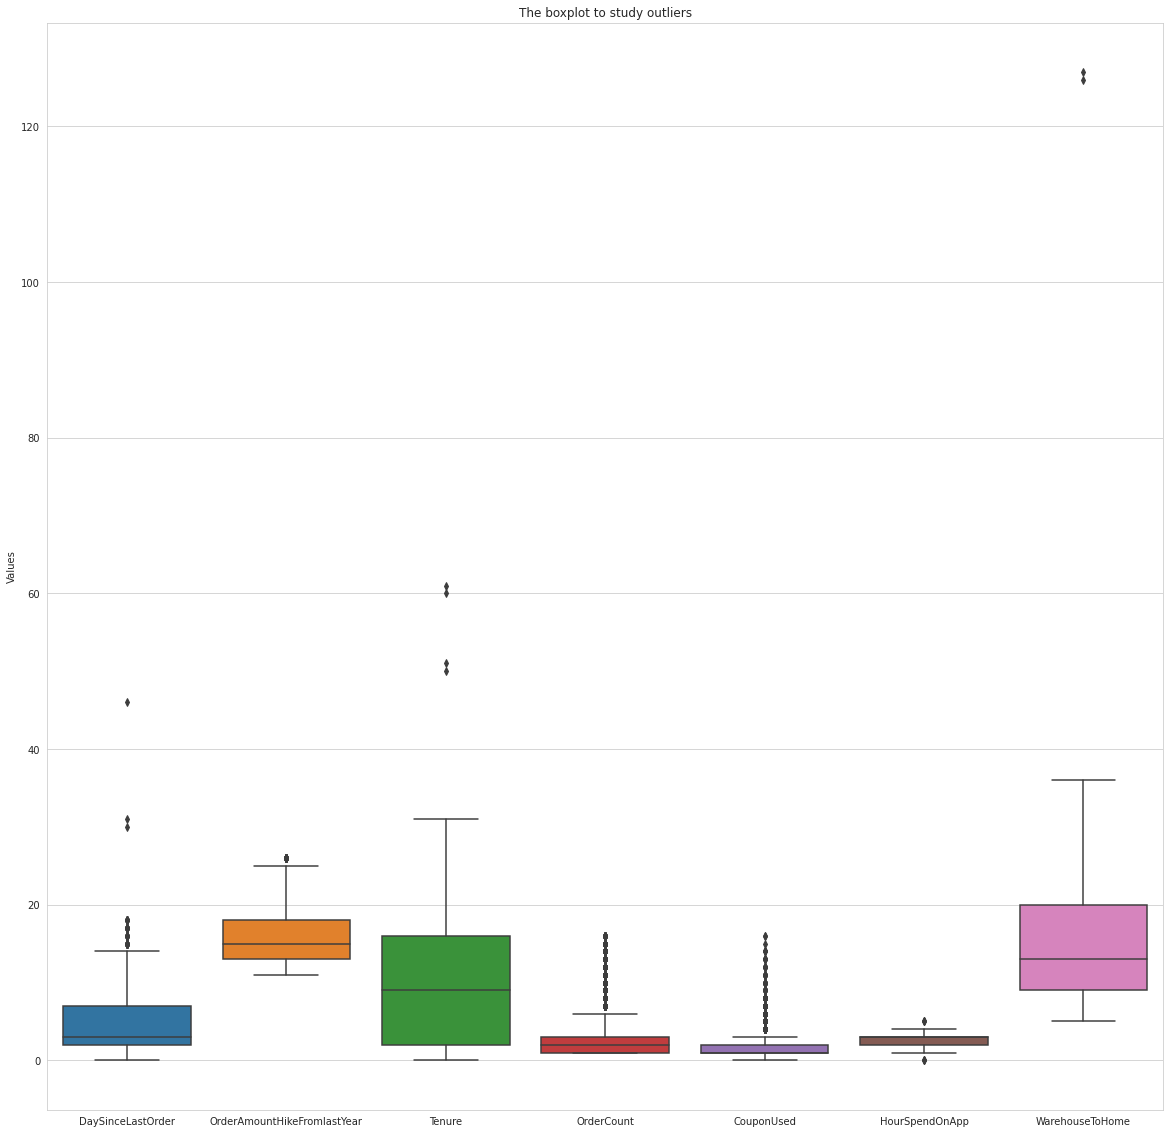

In [ ]:
plt.figure(figsize=(20,20))
sns.boxplot(data=data[['DaySinceLastOrder','OrderAmountHikeFromlastYear','Tenure','OrderCount','CouponUsed','HourSpendOnApp','WarehouseToHome']])
plt.title('The boxplot to study outliers')
plt.ylabel('Values')

In [ ]:
data[['DaySinceLastOrder','OrderAmountHikeFromlastYear','Tenure','OrderCount','CouponUsed','HourSpendOnApp','WarehouseToHome']].describe().transpose()

count  mean  std   min   25%   50%   75%    max
DaySinceLastOrder           4,785.00  4.58 3.66  0.00  2.00  3.00  7.00  46.00
OrderAmountHikeFromlastYear 4,821.00 15.71 3.68 11.00 13.00 15.00 18.00  26.00
Tenure                      4,842.00 10.21 8.59  0.00  2.00  9.00 16.00  61.00
OrderCount                  4,830.00  3.09 3.00  1.00  1.00  2.00  3.00  16.00
CouponUsed                  4,863.00  1.81 1.95  0.00  1.00  1.00  2.00  16.00
HourSpendOnApp              4,843.00  2.93 0.72  0.00  2.00  3.00  3.00   5.00
WarehouseToHome             4,852.00 15.55 8.60  5.00  9.00 13.00 20.00 127.00

Dari grafik dan tabel diatas, didapatkan bahwa feature yang memiliki missing value adalah feature yang memiliki nilai numerik. Untuk itu akan dilakukan handling missing value dengan beberapa cara dengan mempertimbangkan rentang nilai min - max, rentang Q1 - Q3 dan hubungan antar feature akan disesuaikan dengan kondisi missing value dari masing - masing feature, yaitu:

1. 'DaySinceLastOrder' memiliki rentang nilai 0 - 46 dan range antara Q1 hingga Q3 dengan nilai 2 - 7 serta terdapat outlier dalam data, dengan memperhitungkan lebarnya range antara nilai minimum dan maksimum serta hubungan dengan fitur lainnya maka akan dilakukan pengisian missing value menggunakan metode iterative imputer dengan regression model. 


2. 'OrderAmountHikeFromlastYear' memiliki rentang nilai 11 - 26 dan range antara Q1 hingga Q3 dengan nilai 13 - 18 serta terdapat outlier dalam data, dengan memperhitungkan lebarnya range antara nilai minimum dan maksimum serta hubungan dengan fitur lainnya maka akan dilakukan pengisian missing value menggunakan metode iterative imputer dengan regression model.


3. 'Tenure' memiliki rentang nilai 0 - 61 dan range antara Q1 hingga Q3 dengan nilai 2 - 16 serta terdapat outlier dalam data, dengan memperhitungkan lebarnya range antara nilai minimum dan maksimum serta hubungan dengan fitur lainnya maka akan dilakukan pengisian missing value menggunakan metode iterative imputer dengan regression model.  


4. 'OrderCount' memiliki rentang nilai 1 - 16 dan range antara Q1 hingga Q3 dengan nilai 1 - 3 serta terdapat outlier dalam data, dengan memperhitungkan lebarnya range antara nilai minimum dan maksimum serta hubungan dengan fitur lainnya maka akan dilakukan pengisian missing value menggunakan metode iterative imputer dengan regression model.


5. 'CouponUsed' memiliki rentang nilai 0 - 16 dan range antara Q1 hingga Q3 dengan nilai 1 - 2 serta terdapat outlier dalam data, dengan memperhitungkan lebarnya range antara nilai minimum dan maksimum serta hubungan dengan fitur lainnya maka akan dilakukan pengisian missing value menggunakan metode iterative imputer dengan regression model.


6. 'HourSpendOnApp' memiliki rentang nilai 0 - 5 dan range antara Q1 hingga Q3 dengan nilai 2 - 3 serta terdapat outlier dalam data, dengan mempertimbang kecilnya range antara nilai minimum dan maksimum maka akan dilakukan pengisian missing value menggunakan metode simple imputer dengan nilai median.


7. 'WarehouseToHome' memiliki rentang nilai 5 - 127 dan range antara Q1 hingga Q3 dengan nilai 9 - 20 serta terdapat outlier dalam data, dengan memperhitungkan lebarnya range antara nilai minimum dan maksimum serta hubungan dengan fitur lainnya maka akan dilakukan pengisian missing value menggunakan metode iterative imputer dengan regression model.

Iterative imputer merupakan salah satu metode pengisian missing value yang menggunakan fitur lain yang ada dalam data untuk membuat regresi model sehingga menghasilkan suatu nilai untuk missing value tersebut.

Untuk pengisian missing value sesuai penjelasan diatas akan dilakukan bersamaan dengan encoding menggunakan transformer.

### Handling Imputation and One Hot Encoding

In [ ]:
cat_features = ['Tenure','WarehouseToHome','OrderAmountHikeFromlastYear','CouponUsed','OrderCount','DaySinceLastOrder']
cont_features = ['HourSpendOnApp']

In [ ]:
def imputation (data, 
                #x_test,
                cont_features,
                cat_features,
                cont_strategy = 'median',
                cat_strategy = 'most_frequent'
                ):

#initializa object imputer
  imputerCat = SimpleImputer(missing_values=np.nan, strategy= cat_strategy)
  imputerCont = SimpleImputer(missing_values=np.nan, strategy= cont_strategy)

#fit to data train
  imputerCont.fit(data[cont_features])
  imputerCat.fit(data[cat_features])

#transfrom to data
  data[cont_features] = imputerCont.transform(data[cont_features])
  data[cat_features] = imputerCat.transform(data[cat_features])

  return data

In [ ]:
data = imputation(data,cont_features, cat_features)

In [ ]:
data

Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0         1    4.00         Mobile Phone         3             6.00   
1         1    1.00         Mobile Phone         1             8.00   
2         1    1.00         Mobile Phone         1            30.00   
3         1    0.00         Mobile Phone         3            15.00   
4         1    0.00         Mobile Phone         1            12.00   
...     ...     ...                  ...       ...              ...   
5623      0    5.00             Computer         1            12.00   
5624      0    1.00         Mobile Phone         3            12.00   
5626      0   13.00         Mobile Phone         1            13.00   
5627      0    1.00         Mobile Phone         1            11.00   
5629      0    8.00         Mobile Phone         1            15.00   

     PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0              Debit Card  Female            3.00                         3   
1                     UPI    Male            3.00                         4   
2              Debit Card    Male            2.00                         4   
3              Debit Card    Male            2.00                         4   
4             Credit Card    Male            3.00                         3   
...                   ...     ...             ...                       ...   
5623          Credit Card    Male            4.00                         4   
5624                  UPI  Female            2.00                         5   
5626          Credit Card    Male            3.00                         5   
5627           Debit Card    Male            3.00                         2   
5629          Credit Card    Male            3.00                         2   

        PreferedOrderCat  SatisfactionScore MaritalStatus  NumberOfAddress  \
0     Laptop & Accessory                  2        Single                9   
1           Mobile Phone                  3        Single                7   
2           Mobile Phone                  3        Single                6   
3     Laptop & Accessory                  5        Single                8   
4           Mobile Phone                  5        Single                3   
...                  ...                ...           ...              ...   
5623  Laptop & Accessory                  5        Single                2   
5624        Mobile Phone                  3        Single                2   
5626             Fashion                  5       Married                6   
5627  Laptop & Accessory                  4       Married                3   
5629  Laptop & Accessory                  3       Married                4   

      Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
0            1                        11.00        1.00        1.00   
1            1                        15.00        0.00        1.00   
2            1                        14.00        0.00        1.00   
3            0                        23.00        0.00        1.00   
4            0                        11.00        1.00        1.00   
...        ...                          ...         ...         ...   
5623         0                        20.00        2.00        2.00   
5624         0                        19.00        2.00        2.00   
5626         0                        16.00        1.00        2.00   
5627         1                        21.00        1.00        2.00   
5629         0                        13.00        2.00        2.00   

      DaySinceLastOrder  CashbackAmount  
0                  5.00          159.93  
1                  0.00          120.90  
2                  3.00          120.28  
3                  3.00          134.07  
4                  3.00          129.60  
...                 ...             ...  
5623               3.00          224.36  
5624               1.00          154.66  
5626               3.00          224

In [ ]:
data_kmf = data.copy()

In [ ]:
for cat in ['PreferredLoginDevice', 'PreferredPaymentMode', 'PreferedOrderCat', 'MaritalStatus','Gender']:
    onehots = pd.get_dummies(data[cat], prefix=cat)
    data = data.join(onehots)

### Dropping irrelevant columns

In [ ]:
data = data.drop(columns=['PreferredLoginDevice', 'PreferredPaymentMode', 'PreferedOrderCat', 'MaritalStatus','Gender'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5073 entries, 0 to 5629
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Churn                                  5073 non-null   int64  
 1   Tenure                                 5073 non-null   float64
 2   CityTier                               5073 non-null   int64  
 3   WarehouseToHome                        5073 non-null   float64
 4   HourSpendOnApp                         5073 non-null   float64
 5   NumberOfDeviceRegistered               5073 non-null   int64  
 6   SatisfactionScore                      5073 non-null   int64  
 7   NumberOfAddress                        5073 non-null   int64  
 8   Complain                               5073 non-null   int64  
 9   OrderAmountHikeFromlastYear            5073 non-null   float64
 10  CouponUsed                             5073 non-null   float64
 11  Orde

In [ ]:
# Drop that dummy variable that the business considers to be typical of their subscribers
data = data.drop(columns=['PreferredLoginDevice_Mobile Phone', 'PreferredPaymentMode_E wallet', 'PreferedOrderCat_Laptop & Accessory', 'MaritalStatus_Single','Gender_Male'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5073 entries, 0 to 5629
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Churn                                  5073 non-null   int64  
 1   Tenure                                 5073 non-null   float64
 2   CityTier                               5073 non-null   int64  
 3   WarehouseToHome                        5073 non-null   float64
 4   HourSpendOnApp                         5073 non-null   float64
 5   NumberOfDeviceRegistered               5073 non-null   int64  
 6   SatisfactionScore                      5073 non-null   int64  
 7   NumberOfAddress                        5073 non-null   int64  
 8   Complain                               5073 non-null   int64  
 9   OrderAmountHikeFromlastYear            5073 non-null   float64
 10  CouponUsed                             5073 non-null   float64
 11  Orde

# KM Curves

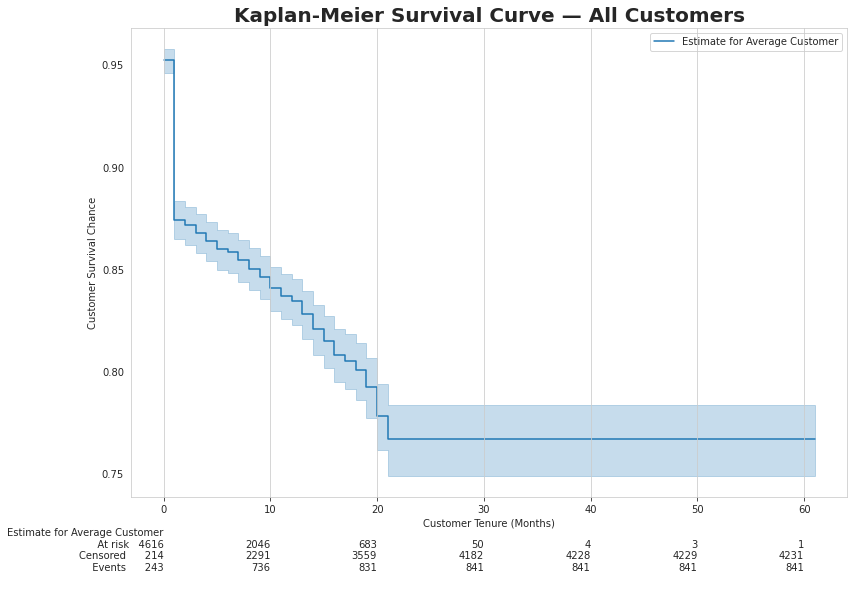

In [ ]:
# Instantiate KMF class with the default 5% CI, can be changed bthrough the alpha parameter
kmf = lifelines.KaplanMeierFitter()

# Fit KMF to our data
kmf.fit(durations = data['Tenure'], event_observed = data['Churn'], label = 'Estimate for Average Customer')

# Plot KM curve
fig, ax = plt.subplots(figsize = (12,8))
kmf.plot(at_risk_counts = True, ax=ax)
ax.set_title('Kaplan-Meier Survival Curve — All Customers',fontsize=20, fontweight='bold')
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance')
ax.grid();

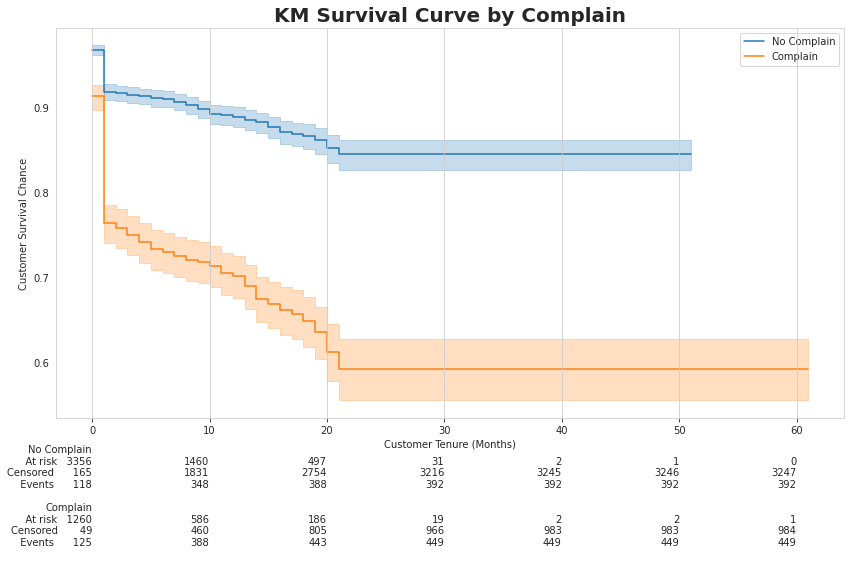

In [ ]:
# save indices for each Complain type
idx_nocomplain = data_kmf['Complain'] == 0
idx_complain = data_kmf['Complain'] > 0

# plot the 3 KM plots for each category
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
kmf_nocomplain = lifelines.KaplanMeierFitter()
ax = kmf_nocomplain.fit(durations = data_kmf.loc[idx_nocomplain, 'Tenure'], event_observed = data_kmf.loc[idx_nocomplain, 'Churn'], label = 'No Complain').plot(ax = ax)
kmf_complain = lifelines.KaplanMeierFitter()
ax = kmf_complain.fit(durations = data_kmf.loc[idx_complain, 'Tenure'], event_observed = data_kmf.loc[idx_complain, 'Churn'], label = 'Complain').plot(ax = ax)

# display title and labels
ax.set_title('KM Survival Curve by Complain',fontsize=20, fontweight='bold')
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance')
plt.grid()

# display at-risk counts for each category
lifelines.plotting.add_at_risk_counts(kmf_nocomplain, kmf_complain, ax = ax);

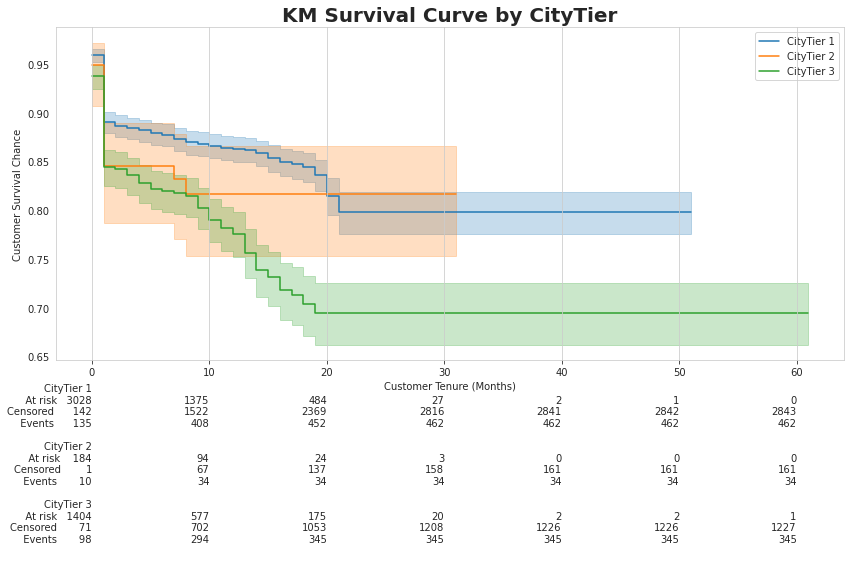

In [ ]:
# save indices for each CityTier type
idx_1 = data_kmf['CityTier'] == 1
idx_2 = data_kmf['CityTier'] == 2
idx_3 = data_kmf['CityTier'] == 3

# plot the 3 KM plots for each category
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
kmf_1 = lifelines.KaplanMeierFitter()
ax = kmf_1.fit(durations = data_kmf.loc[idx_1, 'Tenure'], event_observed = data_kmf.loc[idx_1, 'Churn'], label = 'CityTier 1').plot(ax = ax)
kmf_2 = lifelines.KaplanMeierFitter()
ax = kmf_2.fit(durations = data_kmf.loc[idx_2, 'Tenure'], event_observed = data_kmf.loc[idx_2, 'Churn'], label = 'CityTier 2').plot(ax = ax)
kmf_3 = lifelines.KaplanMeierFitter()
ax = kmf_3.fit(durations = data_kmf.loc[idx_3, 'Tenure'], event_observed = data_kmf.loc[idx_3, 'Churn'], label = 'CityTier 3').plot(ax = ax)

# display title and labels
ax.set_title('KM Survival Curve by CityTier',fontsize=20, fontweight='bold')
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance')
plt.grid()

# display at-risk counts for each category
lifelines.plotting.add_at_risk_counts(kmf_1, kmf_2, kmf_3, ax = ax);

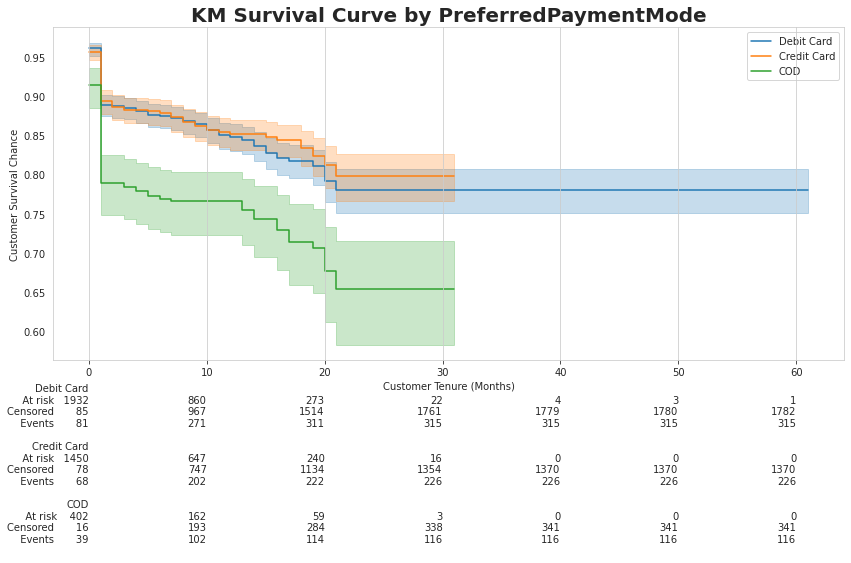

In [ ]:
# save indices for each CityTier type
idx_dc = data_kmf['PreferredPaymentMode'] == 'Debit Card'
idx_cc = data_kmf['PreferredPaymentMode'] == 'Credit Card'
idx_cod = data_kmf['PreferredPaymentMode'] == 'Cash on Delivery'

# plot the 3 KM plots for each category
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
kmf_dc = lifelines.KaplanMeierFitter()
ax = kmf_dc.fit(durations = data_kmf.loc[idx_dc, 'Tenure'], event_observed = data_kmf.loc[idx_dc, 'Churn'], label = 'Debit Card').plot(ax = ax)
kmf_cc = lifelines.KaplanMeierFitter()
ax = kmf_cc.fit(durations = data_kmf.loc[idx_cc, 'Tenure'], event_observed = data_kmf.loc[idx_cc, 'Churn'], label = 'Credit Card').plot(ax = ax)
kmf_cod = lifelines.KaplanMeierFitter()
ax = kmf_cod.fit(durations = data_kmf.loc[idx_cod, 'Tenure'], event_observed = data_kmf.loc[idx_cod, 'Churn'], label = 'COD').plot(ax = ax)

# display title and labels
ax.set_title('KM Survival Curve by PreferredPaymentMode',fontsize=20, fontweight='bold')
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance')
plt.grid()

# display at-risk counts for each category
lifelines.plotting.add_at_risk_counts(kmf_dc, kmf_cc, kmf_cod, ax = ax);

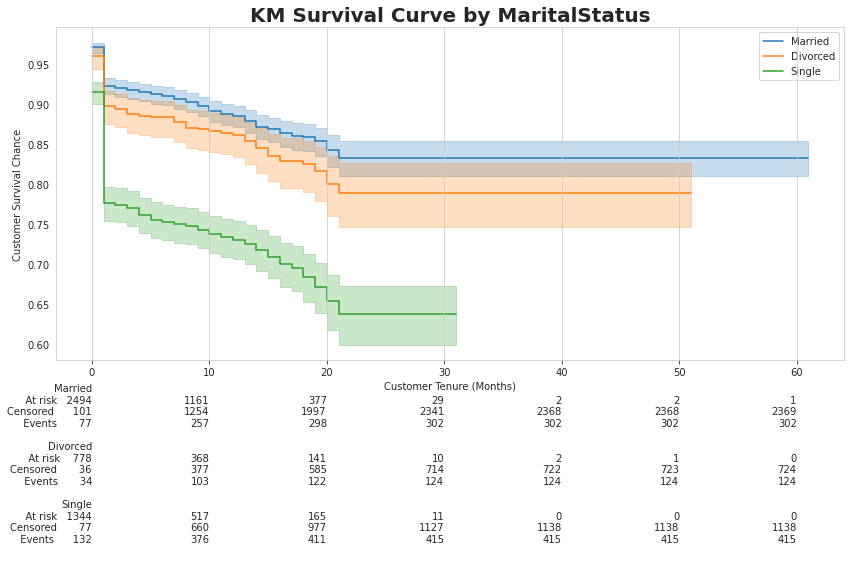

In [ ]:
# save indices for each CityTier type
idx_m = data_kmf['MaritalStatus'] == 'Married'
idx_d = data_kmf['MaritalStatus'] == 'Divorced'
idx_s = data_kmf['MaritalStatus'] == 'Single'

# plot the 3 KM plots for each category
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
kmf_m = lifelines.KaplanMeierFitter()
ax = kmf_m.fit(durations = data_kmf.loc[idx_m, 'Tenure'], event_observed = data_kmf.loc[idx_m, 'Churn'], label = 'Married').plot(ax = ax)
kmf_d = lifelines.KaplanMeierFitter()
ax = kmf_d.fit(durations = data_kmf.loc[idx_d, 'Tenure'], event_observed = data_kmf.loc[idx_d, 'Churn'], label = 'Divorced').plot(ax = ax)
kmf_s = lifelines.KaplanMeierFitter()
ax = kmf_s.fit(durations = data_kmf.loc[idx_s, 'Tenure'], event_observed = data_kmf.loc[idx_s, 'Churn'], label = 'Single').plot(ax = ax)

# display title and labels
ax.set_title('KM Survival Curve by MaritalStatus',fontsize=20, fontweight='bold')
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance')
plt.grid()

# display at-risk counts for each category
lifelines.plotting.add_at_risk_counts(kmf_m, kmf_d, kmf_s, ax = ax);

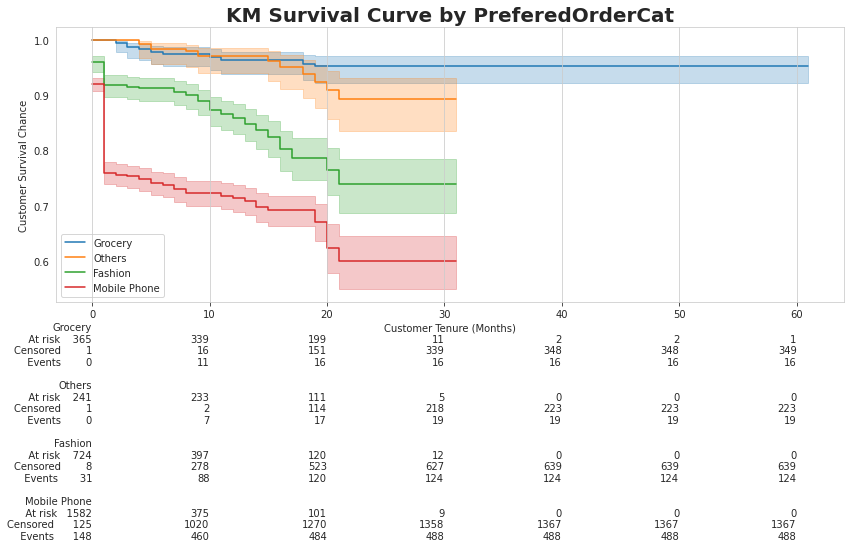

In [ ]:
# save indices for each CityTier type
idx_g = data_kmf['PreferedOrderCat'] == 'Grocery'
idx_o = data_kmf['PreferedOrderCat'] == 'Others'
idx_f = data_kmf['PreferedOrderCat'] == 'Fashion'
idx_mp = data_kmf['PreferedOrderCat'] == 'Mobile Phone'

# plot the 3 KM plots for each category
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
kmf_g = lifelines.KaplanMeierFitter()
ax = kmf_g.fit(durations = data_kmf.loc[idx_g, 'Tenure'], event_observed = data_kmf.loc[idx_g, 'Churn'], label = 'Grocery').plot(ax = ax)
kmf_o = lifelines.KaplanMeierFitter()
ax = kmf_o.fit(durations = data_kmf.loc[idx_o, 'Tenure'], event_observed = data_kmf.loc[idx_o, 'Churn'], label = 'Others').plot(ax = ax)
kmf_f = lifelines.KaplanMeierFitter()
ax = kmf_f.fit(durations = data_kmf.loc[idx_f, 'Tenure'], event_observed = data_kmf.loc[idx_f, 'Churn'], label = 'Fashion').plot(ax = ax)
kmf_mp = lifelines.KaplanMeierFitter()
ax = kmf_mp.fit(durations = data_kmf.loc[idx_mp, 'Tenure'], event_observed = data_kmf.loc[idx_mp, 'Churn'], label = 'Mobile Phone').plot(ax = ax)

# display title and labels
ax.set_title('KM Survival Curve by PreferedOrderCat',fontsize=20, fontweight='bold')
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance')
plt.grid()

# display at-risk counts for each category
lifelines.plotting.add_at_risk_counts(kmf_g, kmf_o, kmf_f,kmf_mp,ax = ax);

# CPH Model Training

In [ ]:
# Instantiate and fit CPH model
cph = lifelines.CoxPHFitter()
cph.fit(data, duration_col = 'Tenure', event_col = 'Churn')

# Print model summary
cph.print_summary(model = 'base model', decimals = 3, columns = ['coef', 'exp(coef)', 'p']) 

<lifelines.CoxPHFitter: fitted with 5073 total observations, 4232 right-censored observations>
             duration col = 'Tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 5073
number of events observed = 841
   partial log-likelihood = -6296.226
         time fit was run = 2022-11-20 06:52:40 UTC
                    model = base model

---
                                        coef  exp(coef)       p
covariate                                                      
CityTier                               0.355      1.426 <0.0005
WarehouseToHome                        0.017      1.017 <0.0005
HourSpendOnApp                        -0.113      0.893   0.052
NumberOfDeviceRegistered               0.330      1.391 <0.0005
SatisfactionScore                      0.224      1.251 <0.0005
NumberOfAddress                        0.055      1.056 <0.0005
Complain                               1.245      3.472 <0.0005
OrderAmountHikeFromlastYear           -0.027      0.973   0.006
CouponUsed                             0.002      1.002   0.930
OrderCount                             0.064      1.066   0.001
DaySinceLastOrder                     -0.085      0.918 <0.0005
CashbackAmount                        -0.013      0.987 <0.0005
PreferredLoginDevice_Computer          0.301      1.352 <0.0005
PreferredPaymentMode_Cash on Delivery  0.250      1.285   0.074
PreferredPaymentMode_Credit Card      -0.288      0.750   0.028
PreferredPaymentMode_Debit Card       -0.263      0.768   0.028
PreferredPaymentMode_UPI              -0.311      0.732   0.066
PreferedOrderCat_Fashion               0.651      1.917 <0.0005
PreferedOrderCat_Grocery              -0.144      0.865   0.628
PreferedOrderCat_Mobile Phone          0.946      2.575 <0.0005
PreferedOrderCat_Others                1.116      3.054   0.002
MaritalStatus_Divorced                -0.650      0.522 <0.0005
MaritalStatus_Married                 -0.941      0.390 <0.0005
Gender_Female                         -0.221      0.802   0.002
---
Concordance = 0.829
Partial AIC = 12640.452
log-likelihood ratio test = 1223.310 on 24 df
-log2(p) of ll-ratio test = 805.834

## Model Validation

Notice that we trained the CPH model on our entire dataset, instead of doing so on a training subset as per the standard machine learning pipeline. Let's take care of this now and be more confident our fitted model through doing k-fold cross validation next.

In [ ]:
# Calculate the average Concordance Index of 5 folds
avg_score = np.mean(lifelines.utils.k_fold_cross_validation(cph, data, 'Tenure', 'Churn', k = 10, scoring_method = 'concordance_index'))
print('The average Concordance Score across 10 folds is: {:.3f}'.format(avg_score))

The average Concordance Score across 10 folds is: 0.823


Excellent - so now we have a trained model with a very high Concordance Index - i.e. good discriminatory power (ablility to correctly classify between churners and non-churners). Let us now assess model's calibration

**Check Model Clabiration**

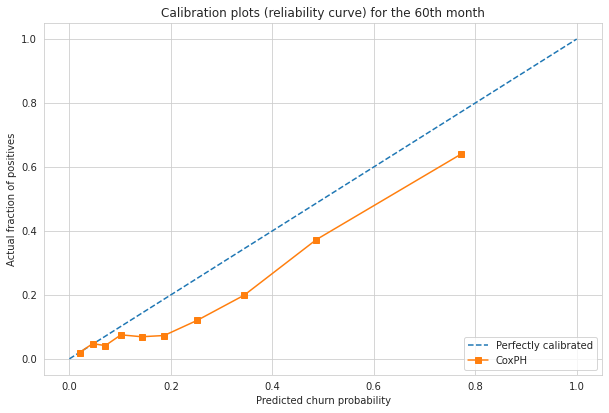

In [ ]:
plt.figure(figsize=(10, 10))
 
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2) 

# Plot the perfectly calibrated line with 0 intercept and 1 slope
ax1.plot([0, 1], [0, 1], ls = '--', label = 'Perfectly calibrated') 

# Calculate the churn probabilities at the end of 12th month. predict_survival_function gives us the survival probability, which we have deducted from 1 to get the churn probability
probs = 1 - np.array(cph.predict_survival_function(data, times = 60).T)

actual = data['Churn'] 
# For each decile, the calibration curve will plot the mean predicted churn probability on the x-axis and its corresponding proportion of observations that actually churned on y-axis, in each bin
fraction_of_positives, mean_predicted_value = calibration_curve(actual, probs, n_bins = 10, strategy = 'quantile') 
ax1.plot(mean_predicted_value, fraction_of_positives, marker = 's', ls = '-', label='CoxPH') 

ax1.set_ylabel("Actual fraction of positives") 
ax1.set_xlabel("Predicted churn probability")
ax1.set_ylim([-0.05, 1.05]) 
ax1.legend(loc="lower right") 
ax1.set_title('Calibration plots (reliability curve) for the 60th month');

In [ ]:
# calculate Brier Score
brier_score = brier_score_loss(data['Churn'], 1 - np.array(cph.predict_survival_function(data, times = 60).T), pos_label = 1)
print('The Brier Score of our CPH Model is {:.2f} at the end of 60 months'.format(brier_score))

The Brier Score of our CPH Model is 0.11 at the end of 60 months


We will now inspect the calibration at each month and draw a curve to represent it visually

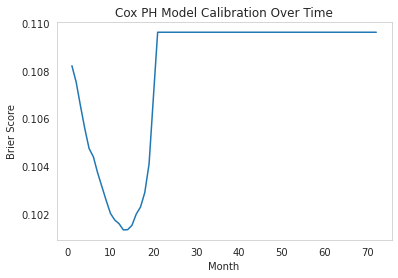

In [ ]:
brier_score_dict = {} 
# Loop over all the months
for i in range(1,73): 
    score = brier_score_loss(data['Churn'], 1 - np.array(cph.predict_survival_function(data, times = i).T), pos_label=1) 
    brier_score_dict[i] = [score] 
# Convert the dict to a DF
brier_score_df = pd.DataFrame(brier_score_dict).T 
# Plot the Brier Score over time
fig, ax = plt.subplots()
ax.plot(brier_score_df)
ax.set(xlabel='Month', ylabel='Brier Score', title='Cox PH Model Calibration Over Time') 
ax.grid()

## CPH Model Visualisation

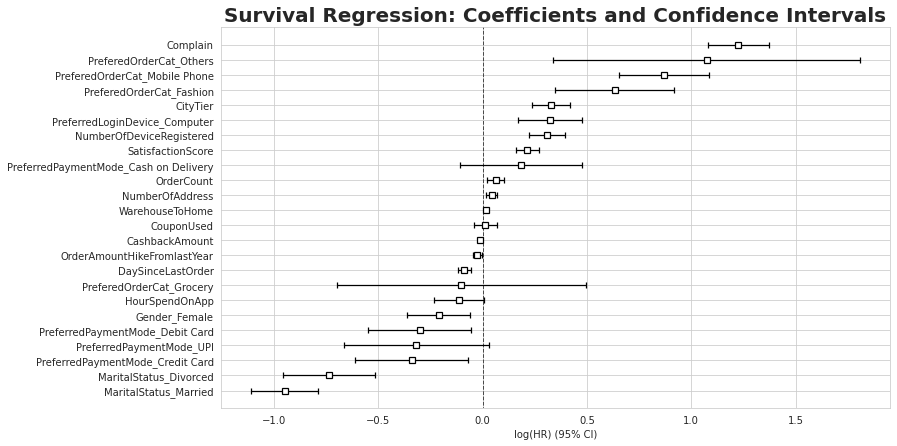

In [ ]:
# Let's plot the coefficient outputs and their respective confidence intervals
fig_coef, ax_coef = plt.subplots(figsize = (12,7))
ax_coef.set_title('Survival Regression: Coefficients and Confidence Intervals',fontsize=20, fontweight='bold')
cph.plot(ax = ax_coef);

Text(0, 0.5, 'Survival Chance (%)')

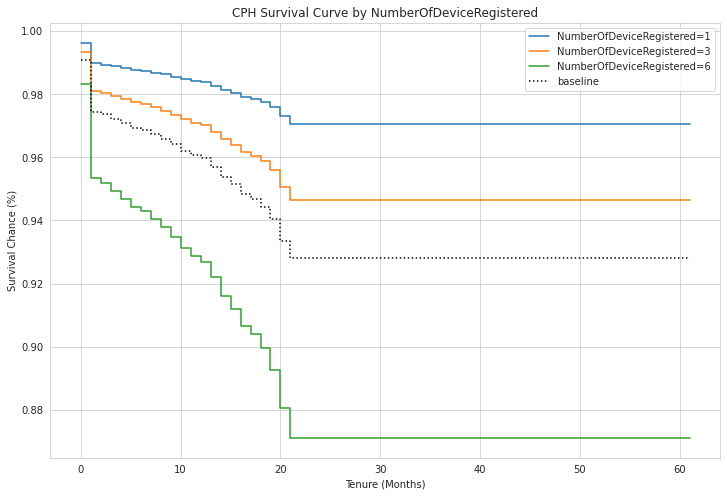

In [ ]:
# Define figure and axes
fig, ax = plt.subplots(figsize = (12,8))
# NumberOfDeviceRegistered
cph.plot_partial_effects_on_outcome('NumberOfDeviceRegistered', values = [1, 3, 6], ax = ax)
ax.set_title('CPH Survival Curve by NumberOfDeviceRegistered')
ax.set_xlabel('Tenure (Months)')
ax.set_ylabel('Survival Chance (%)')

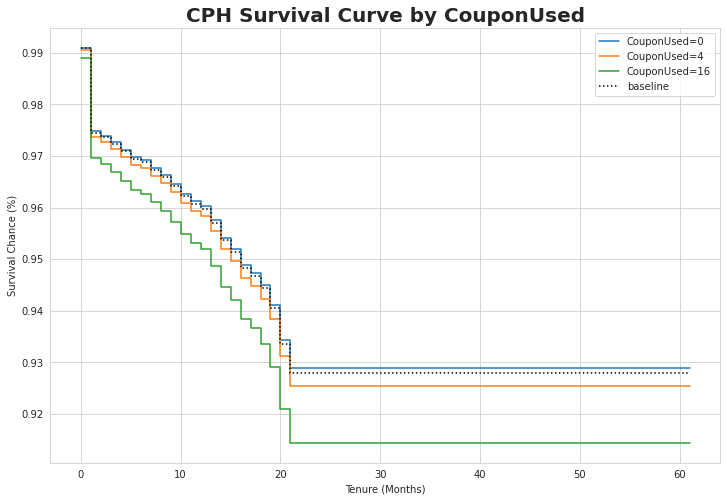

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))
# Complain
cph.plot_partial_effects_on_outcome(['CouponUsed'], values = [0, 4, 16], ax = ax) # we have two arrays in values, 1 for each of the covariate. eq to np.eye(2)
ax.set_title('CPH Survival Curve by CouponUsed',fontsize=20, fontweight='bold')
ax.set_xlabel('Tenure (Months)')
ax.set_ylabel('Survival Chance (%)');

Text(0, 0.5, 'Survival Chance (%)')

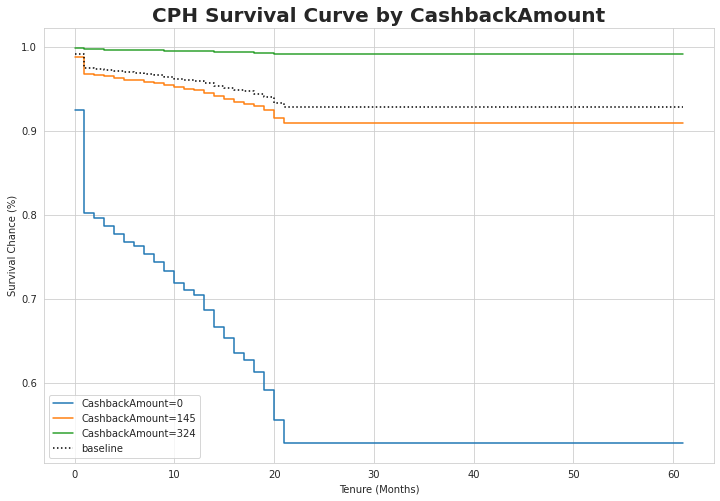

In [ ]:
# Define figure and axes
fig, ax = plt.subplots(figsize = (12,8))
# CashbackAmount
cph.plot_partial_effects_on_outcome('CashbackAmount', values = [0, 145, 324], ax = ax)
ax.set_title('CPH Survival Curve by CashbackAmount',fontsize=20, fontweight='bold')
ax.set_xlabel('Tenure (Months)')
ax.set_ylabel('Survival Chance (%)')

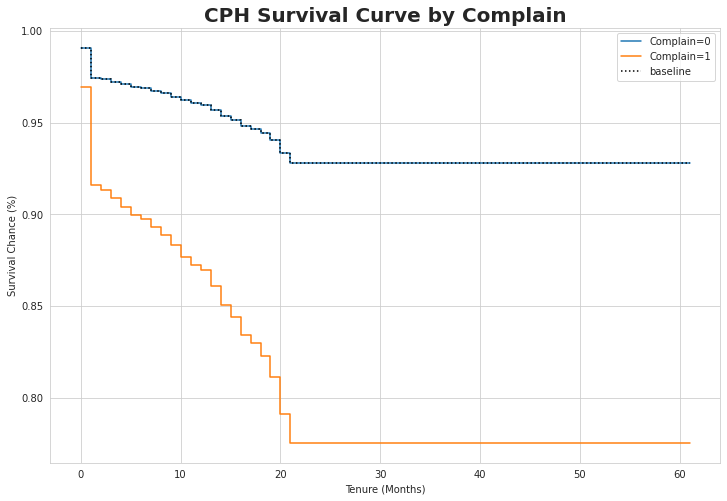

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))
# Complain
cph.plot_partial_effects_on_outcome(['Complain'], values = [0, 1], ax = ax) # we have two arrays in values, 1 for each of the covariate. eq to np.eye(2)
ax.set_title('CPH Survival Curve by Complain',fontsize=20, fontweight='bold')
ax.set_xlabel('Tenure (Months)')
ax.set_ylabel('Survival Chance (%)');

# Churn Prevention

So now we know which covariates we can focus on to reduce churn of our existing right-censored customers, i.e. those that have not churned yet. These features are:
- Having a 1 or 2 year contract term (pretty obvious)
- Automatic payment methods
- No internet and phone services
- DSL internet service
- Paperless billing

In [ ]:
data_kmf

Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0         1    4.00         Mobile Phone         3             6.00   
1         1    1.00         Mobile Phone         1             8.00   
2         1    1.00         Mobile Phone         1            30.00   
3         1    0.00         Mobile Phone         3            15.00   
4         1    0.00         Mobile Phone         1            12.00   
...     ...     ...                  ...       ...              ...   
5623      0    5.00             Computer         1            12.00   
5624      0    1.00         Mobile Phone         3            12.00   
5626      0   13.00         Mobile Phone         1            13.00   
5627      0    1.00         Mobile Phone         1            11.00   
5629      0    8.00         Mobile Phone         1            15.00   

     PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0              Debit Card  Female            3.00                         3   
1                     UPI    Male            3.00                         4   
2              Debit Card    Male            2.00                         4   
3              Debit Card    Male            2.00                         4   
4             Credit Card    Male            3.00                         3   
...                   ...     ...             ...                       ...   
5623          Credit Card    Male            4.00                         4   
5624                  UPI  Female            2.00                         5   
5626          Credit Card    Male            3.00                         5   
5627           Debit Card    Male            3.00                         2   
5629          Credit Card    Male            3.00                         2   

        PreferedOrderCat  SatisfactionScore MaritalStatus  NumberOfAddress  \
0     Laptop & Accessory                  2        Single                9   
1           Mobile Phone                  3        Single                7   
2           Mobile Phone                  3        Single                6   
3     Laptop & Accessory                  5        Single                8   
4           Mobile Phone                  5        Single                3   
...                  ...                ...           ...              ...   
5623  Laptop & Accessory                  5        Single                2   
5624        Mobile Phone                  3        Single                2   
5626             Fashion                  5       Married                6   
5627  Laptop & Accessory                  4       Married                3   
5629  Laptop & Accessory                  3       Married                4   

      Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
0            1                        11.00        1.00        1.00   
1            1                        15.00        0.00        1.00   
2            1                        14.00        0.00        1.00   
3            0                        23.00        0.00        1.00   
4            0                        11.00        1.00        1.00   
...        ...                          ...         ...         ...   
5623         0                        20.00        2.00        2.00   
5624         0                        19.00        2.00        2.00   
5626         0                        16.00        1.00        2.00   
5627         1                        21.00        1.00        2.00   
5629         0                        13.00        2.00        2.00   

      DaySinceLastOrder  CashbackAmount  
0                  5.00          159.93  
1                  0.00          120.90  
2                  3.00          120.28  
3                  3.00          134.07  
4                  3.00          129.60  
...                 ...             ...  
5623               3.00          224.36  
5624               1.00          154.66  
5626               3.00          224

## KM Curves
Let us first draw the historical KM curves of the above shortlisted features that we should focus on

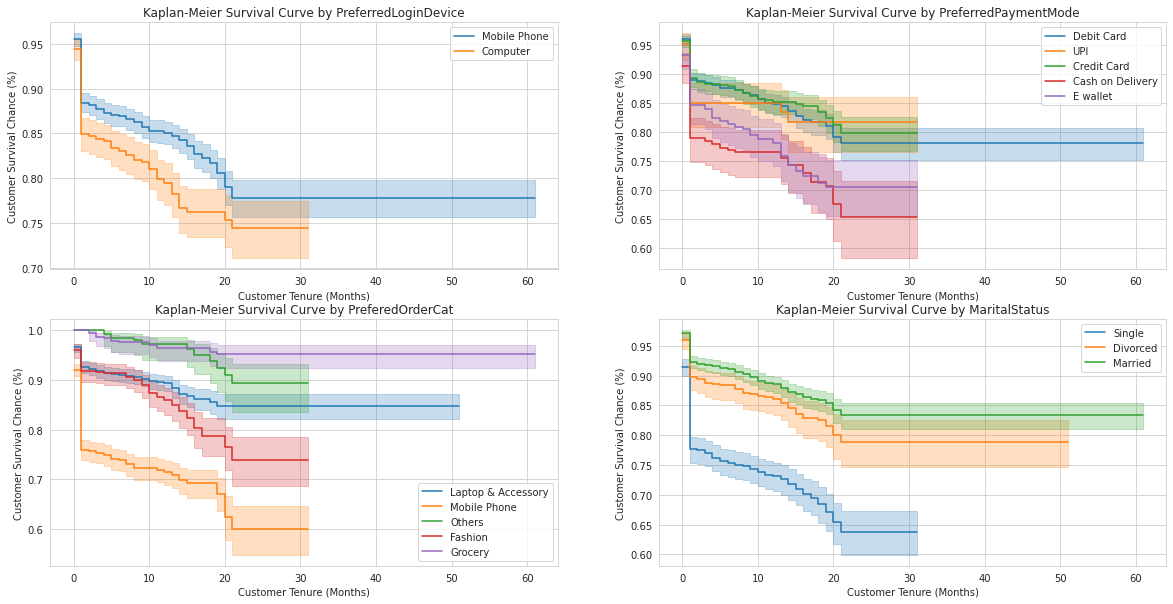

In [ ]:
# We will use the data_kmf that we kept aside for this moment before feature engineering

# function for creating KM curves segmented by categorical variables
def plot_categorical_KM_Curve(feature, t='Tenure', event='Churn', df=data_kmf, ax=None):
    for cat in df[feature].unique():
        idx = df[feature] == cat
        kmf.fit(df[idx][t], event_observed=df[idx][event], label=cat)
        kmf.plot(ax=ax, label=cat)

# call the above function and plot 4 KM Curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize=(20,10))
# PaymentMethod
plot_categorical_KM_Curve(feature='PreferredLoginDevice', ax=ax1)
ax1.set_title('Kaplan-Meier Survival Curve by PreferredLoginDevice')
ax1.set_xlabel('Customer Tenure (Months)')
ax1.set_ylabel('Customer Survival Chance (%)')

# Contract
plot_categorical_KM_Curve(feature='PreferredPaymentMode', ax=ax2)
ax2.set_title('Kaplan-Meier Survival Curve by PreferredPaymentMode')
ax2.set_xlabel('Customer Tenure (Months)')
ax2.set_ylabel('Customer Survival Chance (%)')

# InternetService
plot_categorical_KM_Curve(feature='PreferedOrderCat', ax=ax3)
ax3.set_title('Kaplan-Meier Survival Curve by PreferedOrderCat')
ax3.set_xlabel('Customer Tenure (Months)')
ax3.set_ylabel('Customer Survival Chance (%)')

# PhoneService
plot_categorical_KM_Curve(feature='MaritalStatus', ax=ax4)
ax4.set_title('Kaplan-Meier Survival Curve by MaritalStatus')
ax4.set_xlabel('Customer Tenure (Months)')
ax4.set_ylabel('Customer Survival Chance (%)');

Text(0, 0.5, 'Customer Survival Chance (%)')

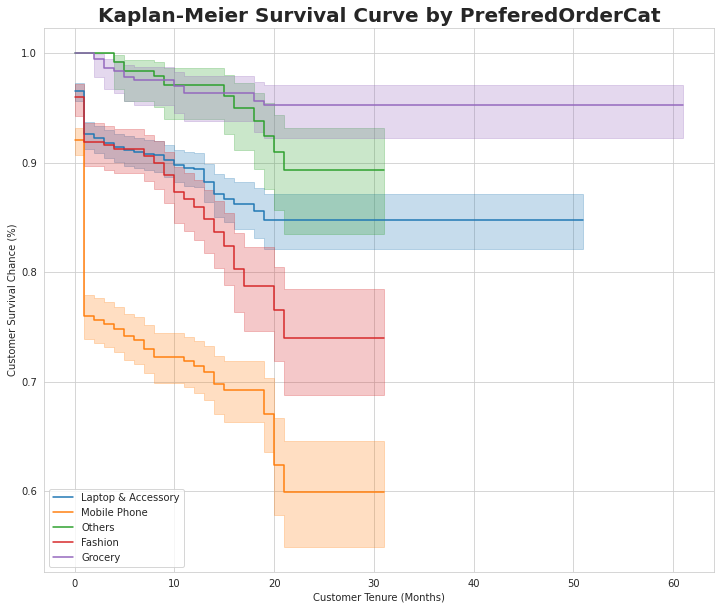

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))

plot_categorical_KM_Curve(feature='PreferedOrderCat', ax=ax)
ax.set_title('Kaplan-Meier Survival Curve by PreferedOrderCat',fontsize=20, fontweight='bold')
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance (%)')

(0.0, 40.0)

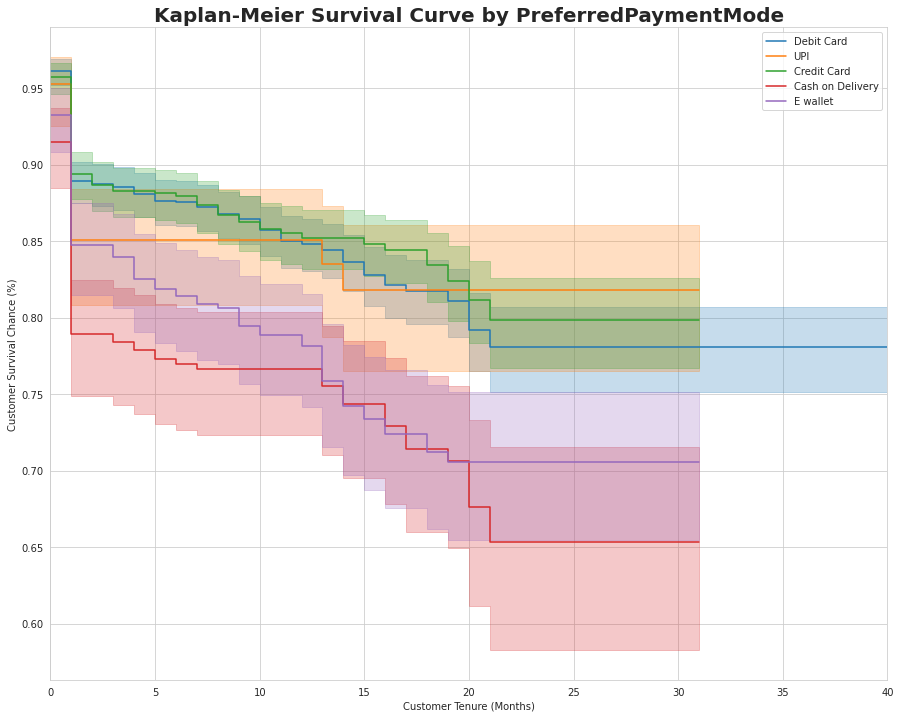

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))
plot_categorical_KM_Curve(feature='PreferredPaymentMode', ax=ax)
ax.set_title('Kaplan-Meier Survival Curve by PreferredPaymentMode',fontsize=20, fontweight='bold')
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance (%)')
ax.set_xlim(0, 40)

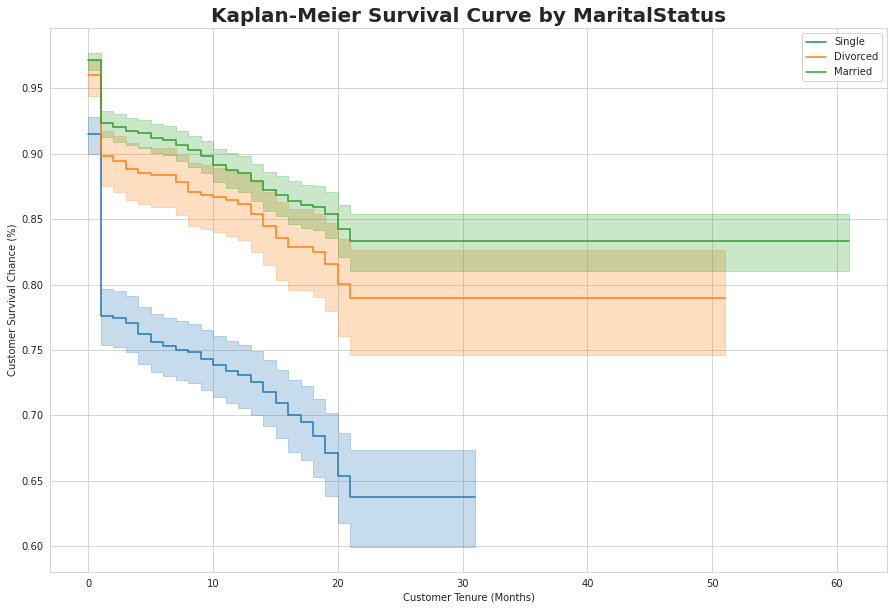

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
plot_categorical_KM_Curve(feature='MaritalStatus', ax=ax)
ax.set_title('Kaplan-Meier Survival Curve by MaritalStatus',fontsize=20, fontweight='bold')
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance (%)');

## CPH Model

Let's now drill down a bit more and focus on censored subjects, i.e. those who have not churned yet. We will predict the future survival function of our censored (not churned) customers - the new timeline is the remaining duration of the customer, i.e. normalized back to starting at 0.

In [ ]:
# Filter censored customers
censored_data = data[data['Churn'] == 0]
# Carve out the tenure column for each customer
censored_data_last_obs = censored_data['Tenure']
# Predict the survival function for each customer from this day onwards
conditioned_sf = cph.predict_survival_function(censored_data, conditional_after = censored_data_last_obs)
conditioned_sf

26    27    28    29    30    31    32    33    34    35    36    37    \
0.00   1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00   
1.00   1.00  0.99  1.00  1.00  1.00  0.98  1.00  1.00  0.99  0.97  1.00  1.00   
2.00   0.99  0.98  0.99  0.99  1.00  0.98  1.00  0.99  0.98  0.97  0.99  0.99   
3.00   0.99  0.97  0.99  0.99  1.00  0.98  1.00  0.99  0.97  0.97  0.98  0.99   
4.00   0.99  0.95  0.99  0.98  0.99  0.98  1.00  0.99  0.96  0.97  0.97  0.99   
5.00   0.98  0.95  0.99  0.97  0.99  0.98  1.00  0.98  0.95  0.97  0.97  0.98   
6.00   0.97  0.94  0.99  0.97  0.99  0.97  1.00  0.98  0.94  0.96  0.96  0.98   
7.00   0.97  0.92  0.99  0.96  0.99  0.97  1.00  0.97  0.93  0.96  0.96  0.98   
8.00   0.96  0.91  0.99  0.95  0.99  0.97  1.00  0.96  0.92  0.96  0.95  0.97   
9.00   0.96  0.89  0.99  0.94  0.99  0.97  1.00  0.96  0.90  0.96  0.94  0.97   
10.00  0.95  0.88  0.99  0.93  0.98  0.97  1.00  0.96  0.89  0.95  0.93  0.96   
11.00  0.94  0.87  0.99  0.92  0.98  0.97  1.00  0.96  0.88  0.95  0.93  0.96   
12.00  0.92  0.85  0.99  0.92  0.98  0.96  1.00  0.96  0.86  0.95  0.91  0.95   
13.00  0.91  0.82  0.99  0.91  0.98  0.96  1.00  0.96  0.84  0.95  0.90  0.94   
14.00  0.91  0.80  0.99  0.89  0.97  0.96  1.00  0.96  0.82  0.94  0.89  0.94   
15.00  0.91  0.78  0.99  0.87  0.97  0.95  1.00  0.96  0.80  0.94  0.87  0.93   
16.00  0.91  0.77  0.99  0.85  0.97  0.95  1.00  0.96  0.79  0.93  0.86  0.93   
17.00  0.91  0.75  0.99  0.85  0.96  0.95  1.00  0.96  0.77  0.93  0.85  0.92   
18.00  0.91  0.72  0.99  0.85  0.96  0.95  1.00  0.96  0.75  0.93  0.83  0.91   
19.00  0.91  0.68  0.99  0.85  0.95  0.94  1.00  0.96  0.70  0.92  0.80  0.89   
20.00  0.91  0.64  0.99  0.85  0.95  0.93  1.00  0.96  0.67  0.91  0.78  0.88   
21.00  0.91  0.64  0.99  0.85  0.95  0.93  1.00  0.96  0.67  0.90  0.78  0.88   
22.00  0.91  0.64  0.99  0.85  0.95  0.93  1.00  0.96  0.67  0.90  0.78  0.88   
23.00  0.91  0.64  0.99  0.85  0.95  0.93  1.00  0.96  0.67  0.90  0.78  0.88   
24.00  0.91  0.64  0.99  0.85  0.95  0.93  1.00  0.96  0.67  0.90  0.78  0.88   
25.00  0.91  0.64  0.99  0.85  0.95  0.93  1.00  0.96  0.67  0.90  0.78  0.88   
26.00  0.91  0.64  0.99  0.85  0.95  0.93  1.00  0.96  0.67  0.90  0.78  0.88   
27.00  0.91  0.64  0.99  0.85  0.95  0.93  1.00  0.96  0.67  0.90  0.78  0.88   
28.00  0.91  0.64  0.99  0.85  0.95  0.93  1.00  0.96  0.67  0.90  0.78  0.88   
29.00  0.91  0.64  0.99  0.85  0.95  0.93  1.00  0.96  0.67  0.90  0.78  0.88   
30.00  0.91  0.64  0.99  0.85  0.95  0.93  1.00  0.96  0.67  0.90  0.78  0.88   
31.00  0.91  0.64  0.99  0.85  0.95  0.93  1.00  0.96  0.67  0.90  0.78  0.88   
50.00  0.91  0.64  0.99  0.85  0.95  0.93  1.00  0.96  0.67  0.90  0.78  0.88   
61.00  0.91  0.64  0.99  0.85  0.95  0.93  1.00  0.96  0.67  0.90  0.78  0.88   

       38    39    40    41    42    43    44    45    47    48    49    50    \
0.00   1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00   
1.00   1.00  0.81  1.00  1.00  1.00  1.00  1.00  0.72  0.98  1.00  0.97  1.00   
2.00   1.00  0.80  1.00  0.99  1.00  0.99  0.99  0.71  0.96  1.00  0.92  1.00   
3.00   1.00  0.79  1.00  0.99  0.99  0.99  0.99  0.69  0.93  1.00  0.89  1.00   
4.00   1.00  0.77  1.00  0.98  0.99  0.98  0.98  0.67  0.90  0.99  0.89  1.00   
5.00   1.00  0.76  1.00  0.98  0.99  0.98  0.97  0.65  0.89  0.99  0.89  1.00   
6.00   1.00  0.75  1.00  0.97  0.99  0.97  0.97  0.64  0.86  0.99  0.89  1.00   
7.00   1.00  0.74  1.00  0.96  0.98  0.97  0.96  0.62  0.84  0.99  0.89  1.00   
8.00   1.00  0.72  1.00  0.96  0.98  0.96  0.95  0.61  0.81  0.99  0.89  1.00   
9.00   1.00  0.71  1.00  0.96  0.98  0.95  0.94  0.59  0.77  0.98  0.89  1.00   
10.00  1.00  0.69  1.00  0.96  0.98  0.94  0.93  0.56  0.75  0.98  0.89  1.00   
11.00  1.00  0.68  1.00  0.96  0.97  0.94  0.92  0.55  0.74  0.98  0.89  1.00   
12.00  1.00  0.67  1.00  0.96  0.97  0.94  0.91  0.53  0.69  0.97  0.89  1.00   
13.00  1.00  0.64  1.00  0.96  0.96  

In [ ]:
# Predict the month where the survival probability falls below the median
predictions_50 = lifelines.utils.median_survival_times(conditioned_sf)
predictions_50

26    27    28    29    30    31    32    33    34    35    36    37    \
0.50   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   

      38    39    40    41    42    43    44    45    47    48    49    50    \
0.50   inf 20.00   inf   inf   inf   inf   inf 14.00 18.00   inf   inf   inf   

      51    53    54    55    56    58    59    60    61    62    63    64    \
0.50   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   

      65    66    68    69    70    71    72    73    74    75    76    77    \
0.50   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   

      78    81    82    83    84    86    87    88    90    93    94    95    \
0.50   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   

      96    97    98    99    100   101   102   103   105   106   107   108   \
0.50   inf   inf   inf   inf   inf 10.00   inf   inf   inf   inf   inf   inf   

      110   112   113   115   116   117   118   119   120   121   122   123   \
0.50   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   

      124   126   127   128   129   130   131   132   133   135   136   137   \
0.50   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   

      138   140   141   142   143   144   145   147   148   149   150   151   \
0.50   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   

      152   153   154   155   156   157   158   159   160   162   164   165   \
0.50   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   

      166   167   169   170   172   173   174   175   176   177   178   179   \
0.50   inf   inf   inf   inf   inf   inf   inf   inf 15.00   inf   inf   inf   

      180   181   182   183   184   185   186   187   188   189   190   191   \
0.50   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   

      193   194   195   196   197   199   200   201   203   204   205   206   \
0.50 13.00   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   

      207   208   209   210   212   213   214   215   216   217   218   219   \
0.50   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   

      220   221   222   223   224   225   226   227   228   229   230   231   \
0.50   inf   inf   inf   inf   inf   inf   inf   inf   inf 16.00   inf   inf   

      233   234   235   236   237   239   240   242   244   246   247   248   \
0.50   inf   inf   inf   inf   inf   inf   inf   inf 12.00   inf   inf   inf   

      249   250   251   252   254   255   256   258   259   261   262   263   \
0.50   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   

      264   265   266   267   268   269   270   271   272   273   274   275   \
0.50   inf   inf   inf   inf   inf   inf   inf   inf 21.00   inf   inf   inf   

      276   277   278   279   281   282   283   284   285   286   287   288   \
0.50   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   

      291   292   293   294   295   298   299   300   301   302   303   304   \
0.50   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   

      305   306   307   308   309   312   313   316   317   319   320   321   \
0.50   inf   inf   inf   inf   inf 18.00   inf   inf   inf   inf   inf   inf   

      322   323   324   325   326   327   329   330   331   333   334   335   \
0.50   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   

      336   337   339   340   341   342   343   345   346   347   348   349   \
0.50   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   

      350   351   352   353   356   358   359   360   361   362   363   364   \
0.50   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   

      365   366   367   368   369   371   372   373   374   375   376   377   \
0.50   inf   inf   inf   inf   inf 10.00   inf   inf   inf   i

In [ ]:
predictions_75 = lifelines.utils.qth_survival_times(0.75, conditioned_sf) # 75% survival chance
predictions_75

26    27    28    29    30    31    32    33    34    35    36    37    \
0.75   inf 18.00   inf   inf   inf   inf   inf   inf 18.00   inf   inf   inf   

      38    39    40    41    42    43    44    45    47    48    49    50    \
0.75   inf  7.00   inf   inf   inf   inf   inf  1.00 11.00   inf   inf   inf   

      51    53    54    55    56    58    59    60    61    62    63    64    \
0.75   inf   inf   inf   inf 19.00   inf   inf   inf   inf   inf   inf   inf   

      65    66    68    69    70    71    72    73    74    75    76    77    \
0.75   inf   inf   inf   inf   inf   inf   inf   inf   inf 20.00   inf 12.00   

      78    81    82    83    84    86    87    88    90    93    94    95    \
0.75   inf 16.00   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   

      96    97    98    99    100   101   102   103   105   106   107   108   \
0.75   inf   inf   inf   inf   inf  5.00   inf   inf   inf   inf   inf   inf   

      110   112   113   115   116   117   118   119   120   121   122   123   \
0.75   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   

      124   126   127   128   129   130   131   132   133   135   136   137   \
0.75   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf 19.00   

      138   140   141   142   143   144   145   147   148   149   150   151   \
0.75   inf   inf   inf   inf   inf   inf   inf   inf   inf 16.00   inf   inf   

      152   153   154   155   156   157   158   159   160   162   164   165   \
0.75   inf   inf   inf   inf   inf   inf   inf 15.00   inf   inf   inf   inf   

      166   167   169   170   172   173   174   175   176   177   178   179   \
0.75   inf 16.00 10.00   inf   inf   inf   inf   inf  1.00   inf   inf   inf   

      180   181   182   183   184   185   186   187   188   189   190   191   \
0.75   inf   inf   inf   inf 16.00   inf   inf   inf   inf   inf   inf   inf   

      193   194   195   196   197   199   200   201   203   204   205   206   \
0.75  1.00 11.00 11.00   inf   inf   inf   inf   inf 14.00   inf   inf 15.00   

      207   208   209   210   212   213   214   215   216   217   218   219   \
0.75   inf   inf   inf   inf 19.00   inf   inf   inf   inf   inf   inf   inf   

      220   221   222   223   224   225   226   227   228   229   230   231   \
0.75   inf   inf   inf   inf   inf  5.00   inf   inf   inf 10.00   inf   inf   

      233   234   235   236   237   239   240   242   244   246   247   248   \
0.75   inf   inf   inf   inf 11.00   inf   inf   inf  7.00 18.00   inf   inf   

      249   250   251   252   254   255   256   258   259   261   262   263   \
0.75   inf   inf   inf   inf   inf 20.00 15.00   inf   inf   inf   inf   inf   

      264   265   266   267   268   269   270   271   272   273   274   275   \
0.75 10.00   inf   inf   inf   inf   inf   inf   inf  9.00   inf 20.00   inf   

      276   277   278   279   281   282   283   284   285   286   287   288   \
0.75   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   

      291   292   293   294   295   298   299   300   301   302   303   304   \
0.75 15.00   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   

      305   306   307   308   309   312   313   316   317   319   320   321   \
0.75 11.00   inf   inf   inf   inf 11.00   inf   inf   inf   inf   inf   inf   

      322   323   324   325   326   327   329   330   331   333   334   335   \
0.75   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   inf   

      336   337   339   340   341   342   343   345   346   347   348   349   \
0.75   inf   inf   inf   inf   inf   inf   inf 17.00   inf   inf   inf 19.00   

      350   351   352   353   356   358   359   360   361   362   363   364   \
0.75   inf   inf   inf   inf 14.00   inf   inf   inf   inf 14.00   inf   inf   

      365   366   367   368   369   371   372   373   374   375   376   377   \
0.75 10.00   inf   inf   inf 11.00  1.00   inf   inf   inf   i

In [ ]:
# We can use this single row and by joining it to our data DF, we can investigate the predicted remaining value a customer has for the business
# Note that we will also append our censored customerIDs that we kept aside at the beginning of the model so as to properly identify our customers
customer_predictions = pd.concat([customerID[['CustomerID', 'CashbackAmount']], predictions_50.T], axis = 1)

# Rename the column returned by median_survival_times function
customer_predictions.rename(columns = {0.5: 'Exp_Churn_Month'}, inplace = True)

# Add another column for the expected loss if these customers were to leave us today
customer_predictions['Exp_Loss'] = customer_predictions['CashbackAmount'] * customer_predictions['Exp_Churn_Month']
customer_predictions

CustomerID  CashbackAmount  Exp_Churn_Month  Exp_Loss
26         50027          172.95              inf       inf
27         50028          123.06              inf       inf
28         50029          123.48              inf       inf
29         50030          189.98              inf       inf
30         50031          143.19              inf       inf
...          ...             ...              ...       ...
5625       55626          150.71              NaN       NaN
5626       55627          224.91              inf       inf
5627       55628          186.42              inf       inf
5628       55629          178.90              NaN       NaN
5629       55630          169.04              inf       inf

[4682 rows x 4 columns]

So now we know how much do we stand to lose in case any of our current customers were to leave us today. Note that Exp_Value of certain customers (1,654 to be precise) have been predicted to infinity - due to their specific correlations between the historical features - we can possibly multiply them by an assumed number of months to get Exp_Loss, e.g. 24 for 2 years corresponding to the length of our 2 year contract. Let's do that next

In [ ]:
# Assign 24 to inf values in Exp_Churn_Month
customer_predictions['Exp_Churn_Month'].replace([np.inf, -np.inf], 20, inplace = True)

# Recalculate the customer_predictions table and sort it
customer_predictions['Exp_Loss'] = customer_predictions['CashbackAmount'] * customer_predictions['Exp_Churn_Month']
customer_predictions.sort_values(by = ['Exp_Loss'], ascending = False)

CustomerID  CashbackAmount  Exp_Churn_Month  Exp_Loss
4350       54351          324.99            20.00  6,499.80
2880       52881          324.99            20.00  6,499.80
4906       54907          324.73            20.00  6,494.60
3436       53437          324.73            20.00  6,494.60
5011       55012          324.43            20.00  6,488.60
...          ...             ...              ...       ...
5611       55612          178.43              NaN       NaN
5613       55614          191.52              NaN       NaN
5620       55621          162.85              NaN       NaN
5625       55626          150.71              NaN       NaN
5628       55629          178.90              NaN       NaN

[4682 rows x 4 columns]

In [ ]:
customer_predictions.dropna(axis=0, inplace = True)

In [ ]:
customer_predictions.shape

(4232, 4)

In [ ]:
censored_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4232 entries, 26 to 5629
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Churn                                  4232 non-null   int64  
 1   Tenure                                 4232 non-null   float64
 2   CityTier                               4232 non-null   int64  
 3   WarehouseToHome                        4232 non-null   float64
 4   HourSpendOnApp                         4232 non-null   float64
 5   NumberOfDeviceRegistered               4232 non-null   int64  
 6   SatisfactionScore                      4232 non-null   int64  
 7   NumberOfAddress                        4232 non-null   int64  
 8   Complain                               4232 non-null   int64  
 9   OrderAmountHikeFromlastYear            4232 non-null   float64
 10  CouponUsed                             4232 non-null   float64
 11  Ord

In [ ]:
# Store the column names to be analysed in a list
upgrades = ['PreferedOrderCat_Grocery', 'PreferredPaymentMode_Credit Card', 'PreferredPaymentMode_Debit Card']
# Define an empty dictionary to hold the results
results_dict = {}

# For each of the potential upgrades, loop through each individual customer to determine the increase in expected median churn month
for customer in customer_predictions.index:  
    actual = censored_data.loc[[customer]] # save the actual cutomer data as a series
    change = censored_data.loc[[customer]] # same as actual but this series will be used to evaluate hypothetical scenarios
    results_dict[customer] = [cph.predict_median(actual, conditional_after=censored_data_last_obs[customer])] # calculate the base median churn month
    for upgrade in upgrades:
        change[upgrade] = 1 if list(change[upgrade]) == 0 else 1 # hypothetical scenario where customer signs up for this particular upgrade
        results_dict[customer].append(cph.predict_median(change, conditional_after = censored_data_last_obs[customer])) # calculate the revised median churn month under the above hypothetical scenario
        change = censored_data.loc[[customer]] # bring the change series back to the original state (i.e. undo the effect of the hypothetical scenario)

# Convert dictionary to a DF and transpose the resultant DF back to the required format (each customer in a separate row)
results_df = pd.DataFrame(results_dict).T 

# add 'baseline' to the beginning of upgrades list. This new list will be used to rename the columns of results_df
column_names = upgrades
column_names.insert(0, 'baseline')
results_df.columns = column_names

# Concat this new df with customer_predictions DF
upgrade_analysis = pd.concat([customer_predictions, results_df], axis = 1) 
upgrade_analysis

CustomerID  CashbackAmount  Exp_Churn_Month  Exp_Loss  baseline  \
26         50027          172.95            20.00  3,459.00       inf   
27         50028          123.06            20.00  2,461.20       inf   
28         50029          123.48            20.00  2,469.60       inf   
29         50030          189.98            20.00  3,799.60       inf   
30         50031          143.19            20.00  2,863.80       inf   
...          ...             ...              ...       ...       ...   
5623       55624          224.36            20.00  4,487.20       inf   
5624       55625          154.66            20.00  3,093.20       inf   
5626       55627          224.91            20.00  4,498.20       inf   
5627       55628          186.42            20.00  3,728.40       inf   
5629       55630          169.04            20.00  3,380.80       inf   

      PreferedOrderCat_Grocery  PreferredPaymentMode_Credit Card  \
26                         inf                               inf   
27                         inf                               inf   
28                         inf                               inf   
29                         inf                               inf   
30                         inf                               inf   
...                        ...                               ...   
5623                       inf                               inf   
5624                       inf                               inf   
5626                       inf                               inf   
5627                       inf                               inf   
5629                       inf                               inf   

      PreferredPaymentMode_Debit Card  
26                                inf  
27                                inf  
28                                inf  
29                                inf  
30                                inf  
...                               ...  
5623                              inf  
5624                              inf  
5626                              inf  
5627                              inf  
5629                              inf  

[4232 rows x 8 columns]

In [ ]:
# replace inf values in baseline column with NaN before dropping these rows
upgrade_analysis.replace([np.inf, -np.inf], np.nan, inplace = True)
upgrade_analysis.dropna(axis=0, inplace = True)
upgrade_analysis

CustomerID  CashbackAmount  Exp_Churn_Month  Exp_Loss  baseline  \
45         50046          130.58            14.00  1,828.12     14.00   
47         50048          120.88            18.00  2,175.84     18.00   
101        50102            0.00            10.00      0.00     10.00   
176        50177          112.00            15.00  1,680.00     15.00   
193        50194          124.78            13.00  1,622.14     13.00   
229        50230          147.36            16.00  2,357.76     16.00   
244        50245          126.57            12.00  1,518.84     12.00   
371        50372          134.47            10.00  1,344.70     10.00   
548        50549          127.99            10.00  1,279.90     10.00   
690        50691          120.70            12.00  1,448.40     12.00   
737        50738          122.90            18.00  2,212.20     18.00   
796        50797          121.54            15.00  1,823.10     15.00   
1043       51044          137.60            14.00  1,926.40     14.00   
1072       51073          127.28            15.00  1,909.20     15.00   
1311       51312          123.80             1.00    123.80      1.00   
1515       51516          130.58            17.00  2,219.86     17.00   
1517       51518          120.88            18.00  2,175.84     18.00   
1714       51715          126.57            12.00  1,518.84     12.00   
1841       51842          134.47            11.00  1,479.17     11.00   
2018       52019          127.99             9.00  1,151.91      9.00   
2160       52161          120.70            12.00  1,448.40     12.00   
2266       52267          121.54            15.00  1,823.10     15.00   
2513       52514          137.60            15.00  2,064.00     15.00   
3059       53060          151.57            12.00  1,818.84     12.00   
3186       53187          159.47            18.00  2,870.46     18.00   
3363       53364          152.99            10.00  1,529.90     10.00   
3505       53506          145.70            12.00  1,748.40     12.00   
3611       53612          146.54            16.00  2,344.64     16.00   
4126       54127          148.80             9.00  1,339.20      9.00   
4529       54530          151.57            12.00  1,818.84     12.00   
4656       54657          159.47            18.00  2,870.46     18.00   
4833       54834          152.99            10.00  1,529.90     10.00   
4975       54976          145.70            12.00  1,748.40     12.00   
5081       55082          146.54            16.00  2,344.64     16.00   

      PreferedOrderCat_Grocery  PreferredPaymentMode_Credit Card  \
45                       15.00                             19.00   
47                       19.00                             18.00   
101                      10.00                             11.00   
176                      16.00                             15.00   
193                      14.00                             18.00   
229                      17.00                             18.00   
244                      13.00                             15.00   
371                      13.00                             16.00   
548                      10.00                             13.00   
690                      12.00                             14.00   
737                      18.00                             20.00   
796                      17.00                             15.00   
1043                     16.00                             20.00   
1072                     17.00                             20.00   
1311                      1.00                              1.00   
1515                     19.00                             21.00   
1517                     19.00                             18.00   
1714                     13.00                             15.00   
1841                     13.00                             16.00   
2018                     10.00                             12.00   
2160                  

In [ ]:
# Calculate the difference in months between baseline and each feature's revised tenures and multiple this difference by MonthlyCharges
upgrade_analysis['PreferedOrderCat_Grocery Uplift'] = (upgrade_analysis['PreferedOrderCat_Grocery'] - upgrade_analysis['baseline']) * upgrade_analysis['CashbackAmount'] 
upgrade_analysis['PreferredPaymentMode_Credit Card Uplift'] = (upgrade_analysis['PreferredPaymentMode_Credit Card'] - upgrade_analysis['baseline']) * upgrade_analysis['CashbackAmount'] 
upgrade_analysis['PreferredPaymentMode_Debit Card Uplift'] = (upgrade_analysis['PreferredPaymentMode_Debit Card'] - upgrade_analysis['baseline']) * upgrade_analysis['CashbackAmount']
upgrade_analysis

CustomerID  CashbackAmount  Exp_Churn_Month  Exp_Loss  baseline  \
45         50046          130.58            14.00  1,828.12     14.00   
47         50048          120.88            18.00  2,175.84     18.00   
101        50102            0.00            10.00      0.00     10.00   
176        50177          112.00            15.00  1,680.00     15.00   
193        50194          124.78            13.00  1,622.14     13.00   
229        50230          147.36            16.00  2,357.76     16.00   
244        50245          126.57            12.00  1,518.84     12.00   
371        50372          134.47            10.00  1,344.70     10.00   
548        50549          127.99            10.00  1,279.90     10.00   
690        50691          120.70            12.00  1,448.40     12.00   
737        50738          122.90            18.00  2,212.20     18.00   
796        50797          121.54            15.00  1,823.10     15.00   
1043       51044          137.60            14.00  1,926.40     14.00   
1072       51073          127.28            15.00  1,909.20     15.00   
1311       51312          123.80             1.00    123.80      1.00   
1515       51516          130.58            17.00  2,219.86     17.00   
1517       51518          120.88            18.00  2,175.84     18.00   
1714       51715          126.57            12.00  1,518.84     12.00   
1841       51842          134.47            11.00  1,479.17     11.00   
2018       52019          127.99             9.00  1,151.91      9.00   
2160       52161          120.70            12.00  1,448.40     12.00   
2266       52267          121.54            15.00  1,823.10     15.00   
2513       52514          137.60            15.00  2,064.00     15.00   
3059       53060          151.57            12.00  1,818.84     12.00   
3186       53187          159.47            18.00  2,870.46     18.00   
3363       53364          152.99            10.00  1,529.90     10.00   
3505       53506          145.70            12.00  1,748.40     12.00   
3611       53612          146.54            16.00  2,344.64     16.00   
4126       54127          148.80             9.00  1,339.20      9.00   
4529       54530          151.57            12.00  1,818.84     12.00   
4656       54657          159.47            18.00  2,870.46     18.00   
4833       54834          152.99            10.00  1,529.90     10.00   
4975       54976          145.70            12.00  1,748.40     12.00   
5081       55082          146.54            16.00  2,344.64     16.00   

      PreferedOrderCat_Grocery  PreferredPaymentMode_Credit Card  \
45                       15.00                             19.00   
47                       19.00                             18.00   
101                      10.00                             11.00   
176                      16.00                             15.00   
193                      14.00                             18.00   
229                      17.00                             18.00   
244                      13.00                             15.00   
371                      13.00                             16.00   
548                      10.00                             13.00   
690                      12.00                             14.00   
737                      18.00                             20.00   
796                      17.00                             15.00   
1043                     16.00                             20.00   
1072                     17.00                             20.00   
1311                      1.00                              1.00   
1515                     19.00                             21.00   
1517                     19.00                             18.00   
1714                     13.00                             15.00   
1841                     13.00                             16.00   
2018                     10.00                             12.00   
2160                  

In [ ]:
upgrade_analysis.index

Int64Index([  45,   47,  101,  176,  193,  229,  244,  371,  548,  690,  737,
             796, 1043, 1072, 1311, 1515, 1517, 1714, 1841, 2018, 2160, 2266,
            2513, 3059, 3186, 3363, 3505, 3611, 4126, 4529, 4656, 4833, 4975,
            5081],
           dtype='int64')

In [ ]:
target_treatment = upgrade_analysis[['Exp_Loss','PreferedOrderCat_Grocery Uplift','PreferredPaymentMode_Credit Card Uplift','PreferredPaymentMode_Debit Card Uplift']]

In [ ]:
target_treatment.to_dict('index')

{45: {'Exp_Loss': 1828.1200000000001,
  'PreferedOrderCat_Grocery Uplift': 130.58,
  'PreferredPaymentMode_Credit Card Uplift': 652.9000000000001,
  'PreferredPaymentMode_Debit Card Uplift': 522.32},
 47: {'Exp_Loss': 2175.84,
  'PreferedOrderCat_Grocery Uplift': 120.88,
  'PreferredPaymentMode_Credit Card Uplift': 0.0,
  'PreferredPaymentMode_Debit Card Uplift': 241.76},
 101: {'Exp_Loss': 0.0,
  'PreferedOrderCat_Grocery Uplift': 0.0,
  'PreferredPaymentMode_Credit Card Uplift': 0.0,
  'PreferredPaymentMode_Debit Card Uplift': 0.0},
 176: {'Exp_Loss': 1680.0,
  'PreferedOrderCat_Grocery Uplift': 112.0,
  'PreferredPaymentMode_Credit Card Uplift': 0.0,
  'PreferredPaymentMode_Debit Card Uplift': 560.0},
 193: {'Exp_Loss': 1622.14,
  'PreferedOrderCat_Grocery Uplift': 124.78,
  'PreferredPaymentMode_Credit Card Uplift': 623.9,
  'PreferredPaymentMode_Debit Card Uplift': 0.0},
 229: {'Exp_Loss': 2357.76,
  'PreferedOrderCat_Grocery Uplift': 147.36,
  'PreferredPaymentMode_Credit Card Up